# Работа выполнена в рамках соревнования на кусре OpenBio
-  https://www.kaggle.com/competitions/open-bio-spring-2025-final-project

# Overview
When you think of “life hacks,” productivity tricks probably come to mind. But what if a life hack could help you understand your body at a molecular level? It’s not as far‑fetched as it sounds. Every human is made up of roughly 37 trillion cells, and researchers are on a mission to uncover what each one does and how they work together. This understanding could unlock new ways to help us live longer, healthier lives.

To make sense of the complexity, scientists focus on identifying functional tissue units—or FTUs. These are groups of cells that perform a specific job in an organ, like glomeruli in the kidney or alveoli in the lung. Manually marking these structures in microscope images is tedious—an average kidney contains more than a million glomeruli alone. That’s why researchers are turning to AI: they want algorithms that can automatically find and outline FTUs across different organs and datasets, saving time and increasing accuracy.

In this competition, participants are tasked with teaching their models to identify and segment FTUs in images from different human organs. The challenge lies in getting the models precise—accurately outlining each functional unit in every image. Success here could speed up research dramatically, helping scientists better understand how diseases begin, how aging affects organs, and how to promote healthier lives for all.

You’ll be working with tissue microarrays (TMAs), where the tissue is represented by small cores—each a 2 mm diameter circle. These cores have already been divided into 512×512 pixel sections, each accompanied by corresponding binary masks.

## Работа выолнена на домашнем компьютере с видеокартой NVIDIA GeForce RTX 2070 SUPER на 8 Гб, так что суперметрики тут не будет - можности нет. Ноут скорее показ того, что смог сделать при довольно небольших ресурсах

In [1]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
import seaborn as sns
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T


from albumentations.pytorch import ToTensorV2
from collections import Counter
from pprint import pprint
from skimage.measure import label, regionprops
from sklearn.metrics import jaccard_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from tqdm import tqdm, trange

In [3]:
train_fold = pd.read_csv(r"C:\Users\555\Desktop\BioML\Competition\data\train\data\train.csv")

In [5]:
train_fold.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10274  prostate         HPA         512        512         0.4   
1  10274  prostate         HPA         512        512         0.4   
2  10274  prostate         HPA         512        512         0.4   
3  10274  prostate         HPA         512        512         0.4   
4  10274  prostate         HPA         512        512         0.4   

   tissue_thickness   age   sex                 image_path  \
0                 4  76.0  Male  data/train/10274_0003.png   
1                 4  76.0  Male  data/train/10274_0001.png   
2                 4  76.0  Male  data/train/10274_0004.png   
3                 4  76.0  Male  data/train/10274_0000.png   
4                 4  76.0  Male  data/train/10274_0006.png   

                   mask_path    slice_id  
0  data/masks/10274_0003.png  10274_0003  
1  data/masks/10274_0001.png  10274_0001  
2  data/masks/10274_0004.png  10274_0004  
3  data/masks/10274_0000.png  10274_0000  
4  data/masks/10274_0006.png  10274_0006

In [7]:
# Пути
train_csv_path = r"C:\Users\555\Desktop\BioML\Competition\data\train\data\train.csv"
train_images_path = r"C:\Users\555\Desktop\BioML\Competition\data\train\data\train"
train_masks_path = r"C:\Users\555\Desktop\BioML\Competition\data\train\data\masks"
test_images_path = r"C:\Users\555\Desktop\BioML\Competition\data\test\test"
sample_submission_path = r"C:\Users\555\Desktop\BioML\Competition\data\train\data\sample_submission.csv"

## EDA: обзор изображений и масок

In [9]:
for col in train_fold.columns.to_list():
    print(train_fold[col].value_counts())

id
10274    9
10392    9
10611    9
10703    9
10992    9
        ..
24241    4
928      4
23009    4
23880    3
5995     3
Name: count, Length: 210, dtype: int64
organ
kidney            501
prostate          446
largeintestine    296
spleen            287
lung              214
Name: count, dtype: int64
data_source
HPA    1744
Name: count, dtype: int64
img_height
512    1744
Name: count, dtype: int64
img_width
512    1744
Name: count, dtype: int64
pixel_size
0.4    1744
Name: count, dtype: int64
tissue_thickness
4    1744
Name: count, dtype: int64
age
84.0    141
55.0    134
61.0    123
57.0    104
65.0     95
60.0     85
70.0     85
21.0     78
28.0     77
68.0     72
41.0     72
48.0     67
59.0     65
43.0     54
74.0     53
76.0     49
73.0     49
56.0     46
50.0     45
37.0     43
79.0     42
78.0     35
83.0     33
82.0     27
72.0     27
67.0     18
49.0     16
47.0      9
Name: count, dtype: int64
sex
Male      1130
Female     614
Name: count, dtype: int64
image_path
data/trai

In [11]:
train_fold.describe()

id  img_height  img_width  pixel_size  tissue_thickness  \
count   1744.000000      1744.0     1744.0      1744.0            1744.0   
mean   16327.162271       512.0      512.0         0.4               4.0   
std     9801.868241         0.0        0.0         0.0               0.0   
min      144.000000       512.0      512.0         0.4               4.0   
25%     8402.000000       512.0      512.0         0.4               4.0   
50%    16362.000000       512.0      512.0         0.4               4.0   
75%    24269.000000       512.0      512.0         0.4               4.0   
max    32527.000000       512.0      512.0         0.4               4.0   

               age  
count  1744.000000  
mean     59.565940  
std      16.491212  
min      21.000000  
25%      50.000000  
50%      60.000000  
75%      72.000000  
max      84.000000

In [11]:
# Загрузка CSV
train_df = pd.read_csv(train_csv_path)
sample_sub = pd.read_csv(sample_submission_path)

print(f"Кол-во обучающих изображений: {len(os.listdir(train_images_path))}")
print(f"Кол-во обучающих масок:       {len(os.listdir(train_masks_path))}")
print(f"Кол-во тестовых изображений:  {len(os.listdir(test_images_path))}")
print(f"Форма train.csv: {train_df.shape}")
print(f"Форма sample_submission.csv: {sample_sub.shape}")

Кол-во обучающих изображений: 1744
Кол-во обучающих масок:       1744
Кол-во тестовых изображений:  1151
Форма train.csv: (1744, 12)
Форма sample_submission.csv: (2, 3)


In [13]:
# Путь до корневой папки с train
root_dir = Path(r"C:\Users\555\Desktop\BioML\Competition\data\train\data")

# Подкаталоги с изображениями и масками
img_dir  = root_dir / "train"   # изображения
mask_dir = root_dir / "masks"   # маски

# Генерация путей
train_df["image_path"] = train_df["slice_id"].apply(lambda x: img_dir / f"{x}.png")
train_df["mask_path"]  = train_df["slice_id"].apply(lambda x: mask_dir / f"{x}.png")

# Преобразуем в строковый формат
train_df["image_path"] = train_df["image_path"].astype(str)
train_df["mask_path"]  = train_df["mask_path"].astype(str)

# Проверка — первые 3 строки
for i in range(3):
    print(f"[{i}] Slice ID: {train_df['slice_id'].iloc[i]}")
    print(train_df['image_path'].iloc[i], "→", Path(train_df['image_path'].iloc[i]).exists())
    print(train_df['mask_path'].iloc[i], "→", Path(train_df['mask_path'].iloc[i]).exists())

[0] Slice ID: 10274_0003
C:\Users\555\Desktop\BioML\Competition\data\train\data\train\10274_0003.png → True
C:\Users\555\Desktop\BioML\Competition\data\train\data\masks\10274_0003.png → True
[1] Slice ID: 10274_0001
C:\Users\555\Desktop\BioML\Competition\data\train\data\train\10274_0001.png → True
C:\Users\555\Desktop\BioML\Competition\data\train\data\masks\10274_0001.png → True
[2] Slice ID: 10274_0004
C:\Users\555\Desktop\BioML\Competition\data\train\data\train\10274_0004.png → True
C:\Users\555\Desktop\BioML\Competition\data\train\data\masks\10274_0004.png → True


In [15]:
IMG_SIZE = 512 * 512                        

# Функция подсчёта площади
def get_mask_area(relative_mask_path):
    filename = os.path.basename(relative_mask_path)  
    full_path = os.path.join(train_masks_path, filename)
    mask = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Не удалось прочитать маску: {full_path}")
        return 0
    return int((mask > 0).sum())

tqdm.pandas()
train_df["mask_area"] = train_df["mask_path"].progress_apply(get_mask_area)

# Классификация по категории
def area2cat(area, total=IMG_SIZE):
    if area == 0:
        return "Empty"
    if area <= 0.01 * total:
        return "Tiny"
    if area <= 0.20 * total:
        return "Small"
    return "Full"

train_df["mask_category"] = train_df["mask_area"].apply(area2cat)

100%|██████████| 1744/1744 [00:03<00:00, 449.02it/s]


In [19]:
train_df["mask_category"].value_counts()

mask_category
Small    704
Empty    614
Full     314
Tiny     112
Name: count, dtype: int64

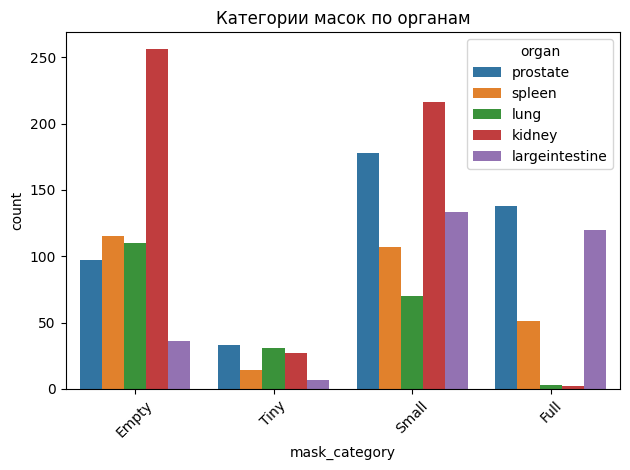

In [21]:
sns.countplot(x="mask_category", hue="organ", data=train_df,
              order=["Empty", "Tiny", "Small", "Full"])
plt.title("Категории масок по органам")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Создаём комбинированную метку
train_df["organ_cat"] = train_df["organ"] + "__" + train_df["mask_category"]

# Считаем количество примеров каждой комбинации
combo_counts = train_df["organ_cat"].value_counts().to_dict()

# Вычисляем инверсные веса: чем реже, тем больше вес
inv_weights = {k: 1.0 / v for k, v in combo_counts.items()}

# Назначаем вес каждой строке
train_df["sample_weight"] = train_df["organ_cat"].map(inv_weights)

In [25]:
train_df[["organ_cat", "sample_weight"]].drop_duplicates().sort_values("sample_weight", ascending=False).head(10)

organ_cat  sample_weight
811           kidney__Full       0.500000
197             lung__Full       0.333333
362   largeintestine__Tiny       0.142857
48            spleen__Tiny       0.071429
26            kidney__Tiny       0.037037
159             lung__Tiny       0.032258
54          prostate__Tiny       0.030303
36   largeintestine__Empty       0.027778
13            spleen__Full       0.019608
23             lung__Small       0.014286

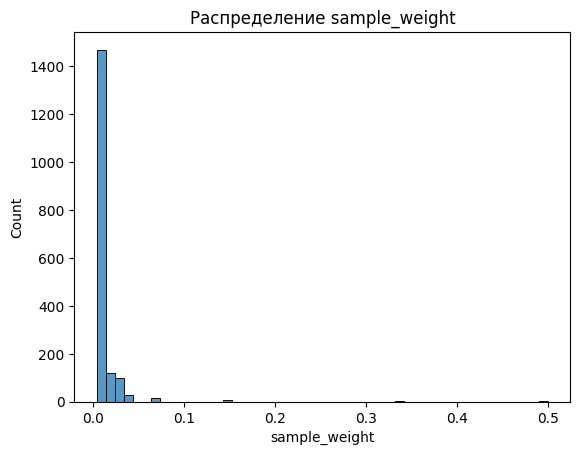

In [29]:
sns.histplot(train_df["sample_weight"], bins=50)
plt.title("Распределение sample_weight")
plt.show()

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_df.index.values
y = train_df["organ_cat"].values

train_idx, val_idx = next(skf.split(X, y))

train_fold = train_df.iloc[train_idx].reset_index(drop=True)
val_fold   = train_df.iloc[val_idx].reset_index(drop=True)

# Быстрая проверка, что страты равномерны
print(train_fold["organ_cat"].value_counts().head())
print(val_fold["organ_cat"].value_counts().head())

organ_cat
kidney__Empty            204
kidney__Small            173
prostate__Small          142
prostate__Full           110
largeintestine__Small    106
Name: count, dtype: int64
organ_cat
kidney__Empty            52
kidney__Small            43
prostate__Small          36
prostate__Full           28
largeintestine__Small    27
Name: count, dtype: int64


D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [31]:
missing_in_val = set(train_fold["organ_cat"]) - set(val_fold["organ_cat"])
print("Комбинации, отсутствующие в валидации:", missing_in_val)

Комбинации, отсутствующие в валидации: {'lung__Full', 'kidney__Full'}


In [33]:
print("Train:", train_fold["mask_category"].value_counts(normalize=True))
print("Val:", val_fold["mask_category"].value_counts(normalize=True))

Train: mask_category
Small    0.403584
Empty    0.351254
Full     0.180645
Tiny     0.064516
Name: proportion, dtype: float64
Val: mask_category
Small    0.404011
Empty    0.355301
Full     0.177650
Tiny     0.063037
Name: proportion, dtype: float64


In [35]:
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_fold = train_df.iloc[train_idx]
    val_fold = train_df.iloc[val_idx]
    missing = set(train_fold["organ_cat"]) - set(val_fold["organ_cat"])
    if len(missing) == 0:
        print(f"Фолда {i} — содержит все классы.")
        break

Фолда 2 — содержит все классы.


D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


## Визуализация случайных изображений и масок

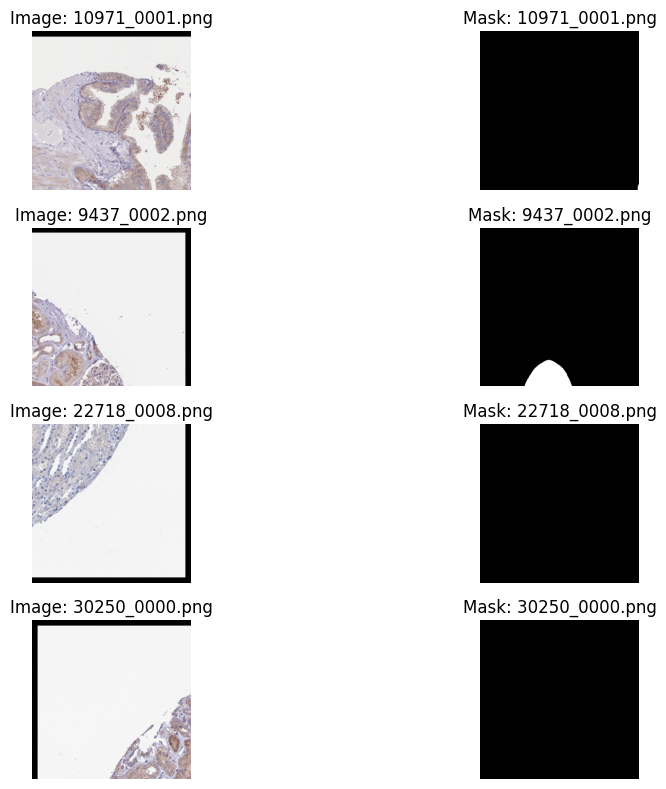

In [41]:
def show_random_images_masks(n=6):
    image_files = os.listdir(train_images_path)
    selected = random.sample(image_files, n)

    plt.figure(figsize=(12, n * 2))
    for i, file in enumerate(selected):
        img_path = os.path.join(train_images_path, file)
        mask_path = os.path.join(train_masks_path, file)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(image)
        plt.title(f"Image: {file}")
        plt.axis("off")

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask: {file}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_random_images_masks(n=4)

## Анализ плотности масок

Анализ масок: 100%|██████████| 1744/1744 [00:02<00:00, 820.16it/s]


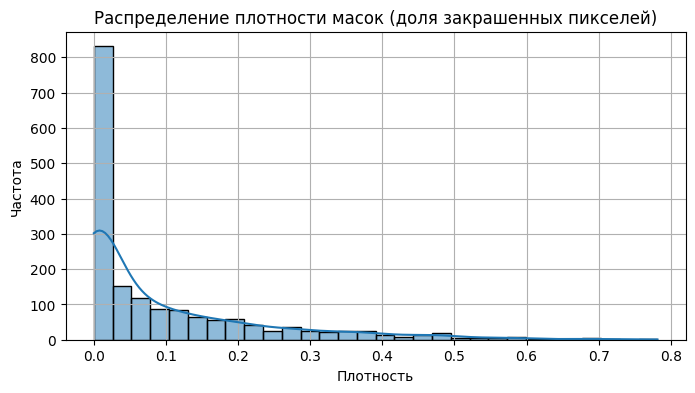

Средняя плотность маски: 0.0965
Пустых масок: 614


In [16]:
mask_densities = []

for file in tqdm(os.listdir(train_masks_path), desc="Анализ масок"):
    mask = cv2.imread(os.path.join(train_masks_path, file), cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        nonzero = np.count_nonzero(mask)
        total = mask.shape[0] * mask.shape[1]
        density = nonzero / total
        mask_densities.append(density)

mask_densities = np.array(mask_densities)

plt.figure(figsize=(8, 4))
sns.histplot(mask_densities, bins=30, kde=True)
plt.title("Распределение плотности масок (доля закрашенных пикселей)")
plt.xlabel("Плотность")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

print(f"Средняя плотность маски: {mask_densities.mean():.4f}")
print(f"Пустых масок: {(mask_densities == 0).sum()}")

In [18]:
def overlay_mask(image, mask, alpha=0.4):
    color_mask = np.zeros_like(image)
    color_mask[:, :, 1] = mask  # маска в зелёный канал
    blended = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)
    return blended

In [20]:
def show_random_masks_with_props(n=4):
    image_files = os.listdir(train_images_path)
    selected = random.sample(image_files, n)

    for i, file in enumerate(selected):
        img_path = os.path.join(train_images_path, file)
        mask_path = os.path.join(train_masks_path, file)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        overlayed = overlay_mask(image, mask)

        # Вычисляем морфологические свойства
        label_img = label(mask)
        regions = regionprops(label_img)

        print(f"\nФайл: {file} — Найдено объектов: {len(regions)}")
        for idx, region in enumerate(regions):
            print(f"Объект {idx+1}:")
            print(f"Площадь (area): {region.area}")
            print(f"Эксцентриситет (eccentricity): {region.eccentricity:.3f}")
            print(f"Солидность (solidity): {region.solidity:.3f}")
            print(f"Прямоуг. площадь (bbox_area): {region.bbox_area}")
            print(f"Эквивалентный диаметр: {region.equivalent_diameter:.2f}")

        plt.figure(figsize=(6, 6))
        plt.imshow(overlayed)
        plt.title(f"{file} — overlay + {len(regions)} объектов")
        plt.axis("off")
        plt.show()


Файл: 31727_0003.png — Найдено объектов: 19
Объект 1:
Площадь (area): 1292.0
Эксцентриситет (eccentricity): 0.752
Солидность (solidity): 0.970
Прямоуг. площадь (bbox_area): 1806.0
Эквивалентный диаметр: 40.56
Объект 2:
Площадь (area): 1445.0
Эксцентриситет (eccentricity): 0.934
Солидность (solidity): 0.967
Прямоуг. площадь (bbox_area): 2184.0
Эквивалентный диаметр: 42.89
Объект 3:
Площадь (area): 5141.0
Эксцентриситет (eccentricity): 0.870
Солидность (solidity): 0.985
Прямоуг. площадь (bbox_area): 6660.0
Эквивалентный диаметр: 80.91
Объект 4:
Площадь (area): 4203.0
Эксцентриситет (eccentricity): 0.771
Солидность (solidity): 0.980
Прямоуг. площадь (bbox_area): 5504.0
Эквивалентный диаметр: 73.15
Объект 5:
Площадь (area): 1304.0
Эксцентриситет (eccentricity): 0.890
Солидность (solidity): 0.982
Прямоуг. площадь (bbox_area): 1904.0
Эквивалентный диаметр: 40.75
Объект 6:
Площадь (area): 1.0
Эксцентриситет (eccentricity): 0.000
Солидность (solidity): 1.000
Прямоуг. площадь (bbox_area): 1.0


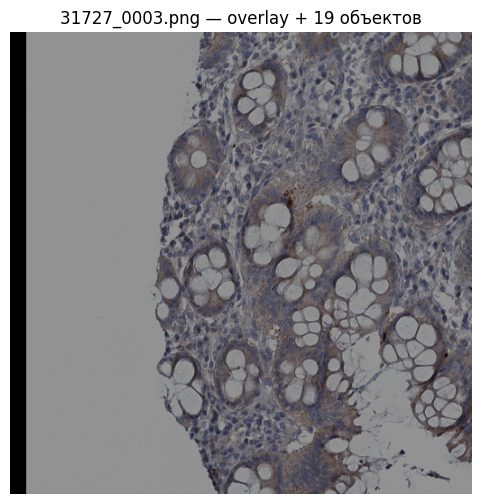


Файл: 12827_0007.png — Найдено объектов: 1
Объект 1:
Площадь (area): 1674.0
Эксцентриситет (eccentricity): 0.817
Солидность (solidity): 0.758
Прямоуг. площадь (bbox_area): 3360.0
Эквивалентный диаметр: 46.17


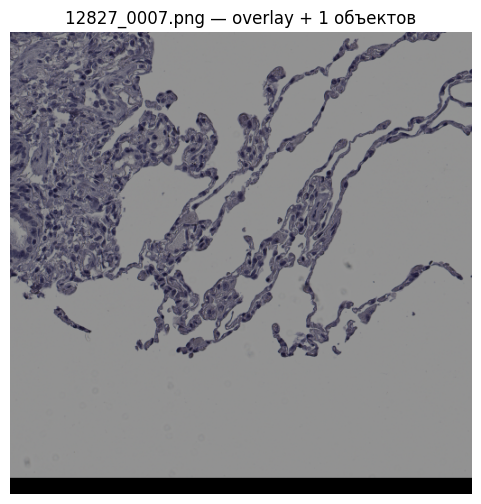


Файл: 1850_0002.png — Найдено объектов: 0


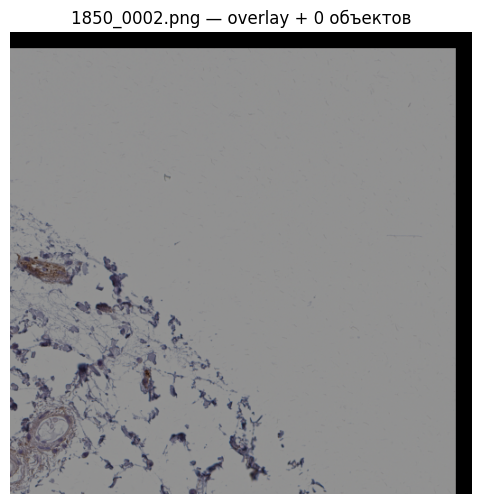

In [22]:
show_random_masks_with_props(n=3)

## Функция для отображения случайных overlay-масок

In [24]:
def show_random_overlayed_masks(n=4):
    image_files = os.listdir(train_images_path)
    selected = random.sample(image_files, n)

    plt.figure(figsize=(12, n * 3))
    for i, file in enumerate(selected):
        img_path = os.path.join(train_images_path, file)
        mask_path = os.path.join(train_masks_path, file)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        overlayed = overlay_mask(image, mask)

        plt.subplot(n, 1, i + 1)
        plt.imshow(overlayed)
        plt.title(f"{file} — overlay")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

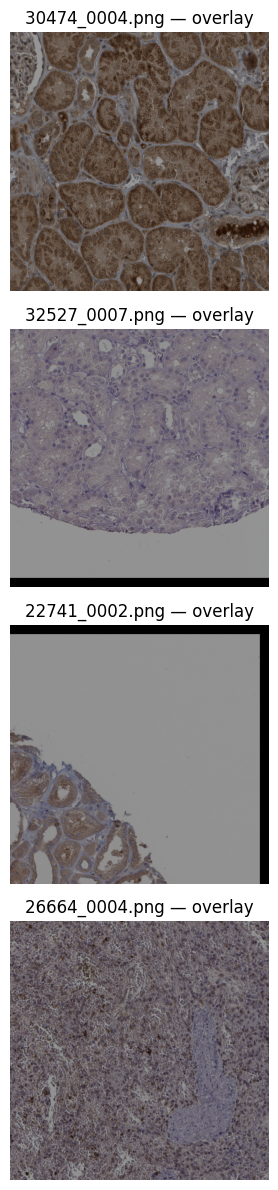

In [26]:
show_random_overlayed_masks(n=4)

## Дополнительный анализ

100%|██████████| 1744/1744 [00:04<00:00, 424.26it/s]


Общее количество масок: 1744
Средняя площадь маски: 25283.95 пикселей
Медианная площадь маски: 8520.00 пикселей
Масок с нулевой площадью: 614
Количество масок с неправильной формой: 0


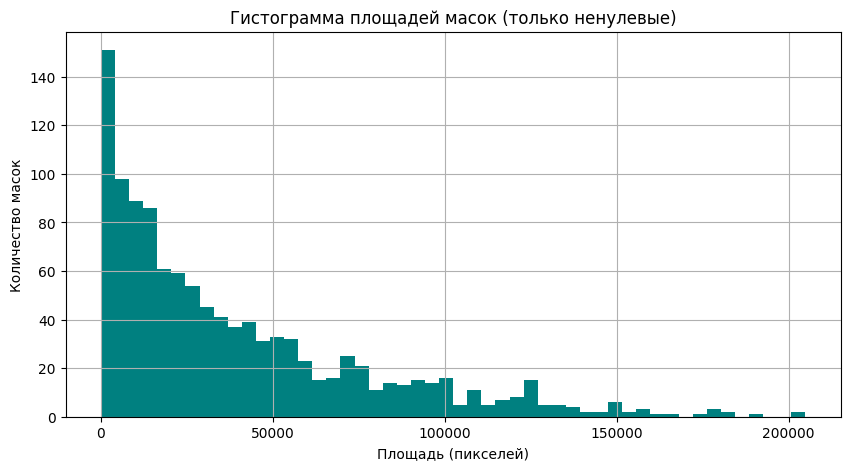

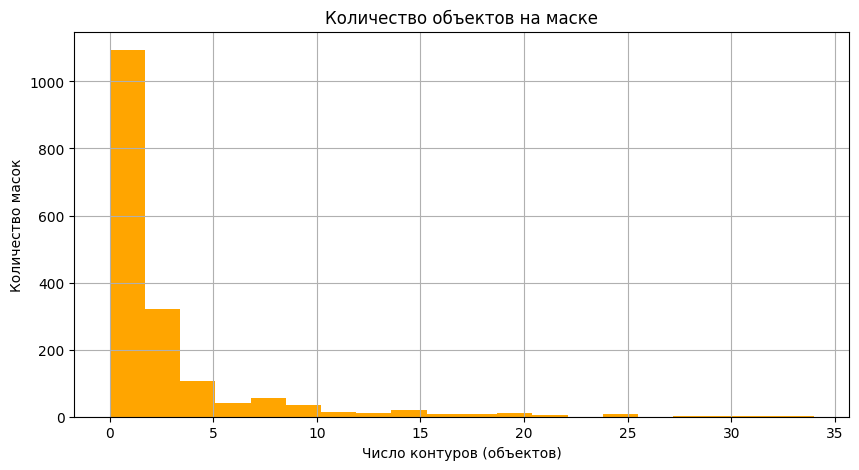

In [16]:
mask_areas = []
num_objects = []
shape_mismatch_count = 0

for filename in tqdm(sorted(os.listdir(train_masks_path))):
    mask_path = os.path.join(train_masks_path, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Проверка формы маски
    if mask.shape != (512, 512):
        shape_mismatch_count += 1
        print(f"[SHAPE MISMATCH] {filename} — {mask.shape}")

    # Подсчёт площади (количество ненулевых пикселей)
    area = np.sum(mask > 0)
    mask_areas.append(area)

    # Подсчёт количества объектов (контуров)
    contours, _ = cv2.findContours((mask > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_objects.append(len(contours))

# Cтатистикa по площадям
mask_areas = np.array(mask_areas)
print(f"Общее количество масок: {len(mask_areas)}")
print(f"Средняя площадь маски: {mask_areas.mean():.2f} пикселей")
print(f"Медианная площадь маски: {np.median(mask_areas):.2f} пикселей")
print(f"Масок с нулевой площадью: {np.sum(mask_areas == 0)}")
print(f"Количество масок с неправильной формой: {shape_mismatch_count}")

# Гистограмма площадей
plt.figure(figsize=(10, 5))
plt.hist(mask_areas[mask_areas > 0], bins=50, color='teal')
plt.title("Гистограмма площадей масок (только ненулевые)")
plt.xlabel("Площадь (пикселей)")
plt.ylabel("Количество масок")
plt.grid(True)
plt.show()

# Гистограмма количества объектов
plt.figure(figsize=(10, 5))
plt.hist(num_objects, bins=20, color='orange')
plt.title("Количество объектов на маске")
plt.xlabel("Число контуров (объектов)")
plt.ylabel("Количество масок")
plt.grid(True)
plt.show()

## Анализ изображений по HSV-доминанте и кластеризация

In [15]:
# Получим список image_ids
image_ids = [f.split('.')[0] for f in os.listdir(train_images_path) if f.endswith('.png')]

# Функции
def get_dominant_color_hsv(image, k=1):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(image)
    return kmeans.cluster_centers_[0]  # возвращаем первую (основную)

def read_mask_info(image_id):
    mask_path = os.path.join(train_masks_path, f"{image_id}.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return 0, 0.0
    area = np.sum(mask > 0)
    total = mask.shape[0] * mask.shape[1]
    return area, area / total

# Сбор данных
metadata = []

for image_id in tqdm(image_ids, desc="Обработка изображений"):
    img_path = os.path.join(train_images_path, f"{image_id}.png")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, _ = img.shape
    hsv_dominant = get_dominant_color_hsv(img)
    mask_area, mask_density = read_mask_info(image_id)

    metadata.append([image_id, width, height, mask_area, mask_density, *hsv_dominant])

cols = ['image_id', 'width', 'height', 'mask_area', 'mask_density', 'H', 'S', 'V']
df = pd.DataFrame(metadata, columns=cols)

Обработка изображений: 100%|██████████| 1744/1744 [01:45<00:00, 16.59it/s]


## Кластеризация и визуализация

hsv_cluster
0    211
1    850
2    683
Name: image_id, dtype: int64

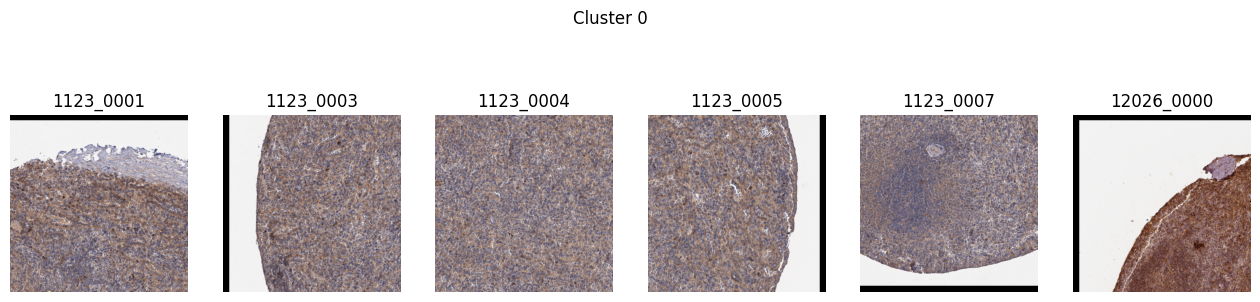

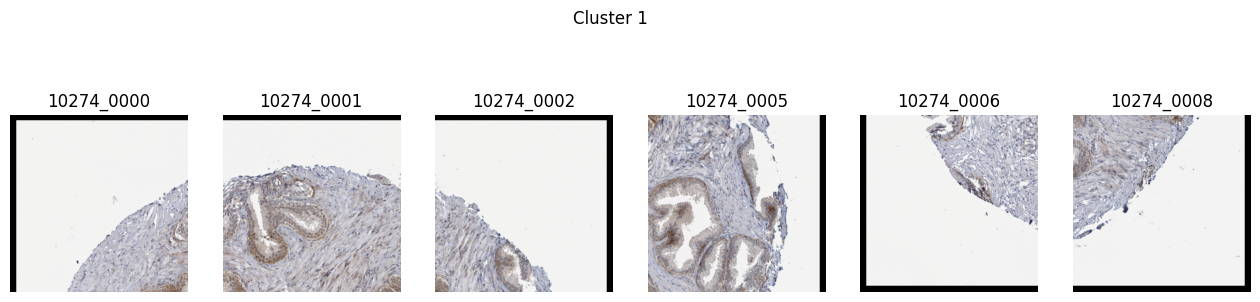

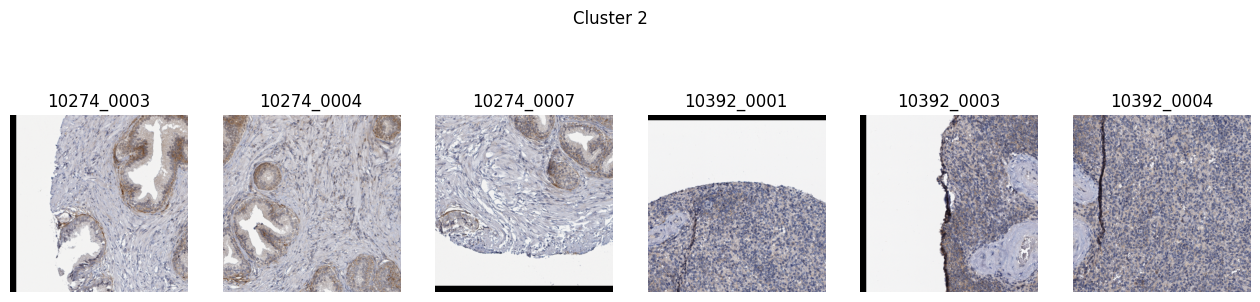

In [17]:
# Кластеризуем по HSV
hsv_features = df[['H', 'S', 'V']].values
kmeans = KMeans(n_clusters=3, random_state=42)
df['hsv_cluster'] = kmeans.fit_predict(hsv_features)

# Сводная по кластерам
display(df.groupby('hsv_cluster')['image_id'].count())

# Примеры изображений из каждого кластера
def plot_cluster_examples(cluster_id, num_images=6):
    ids = df[df['hsv_cluster'] == cluster_id]['image_id'].head(num_images).tolist()
    fig, axs = plt.subplots(1, len(ids), figsize=(16, 4))
    for ax, image_id in zip(axs, ids):
        img_path = os.path.join(train_images_path, f"{image_id}.png")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(image_id)
        ax.axis('off')
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()

for i in range(3):
    plot_cluster_examples(i)

## Распределение плотности масок по кластерам

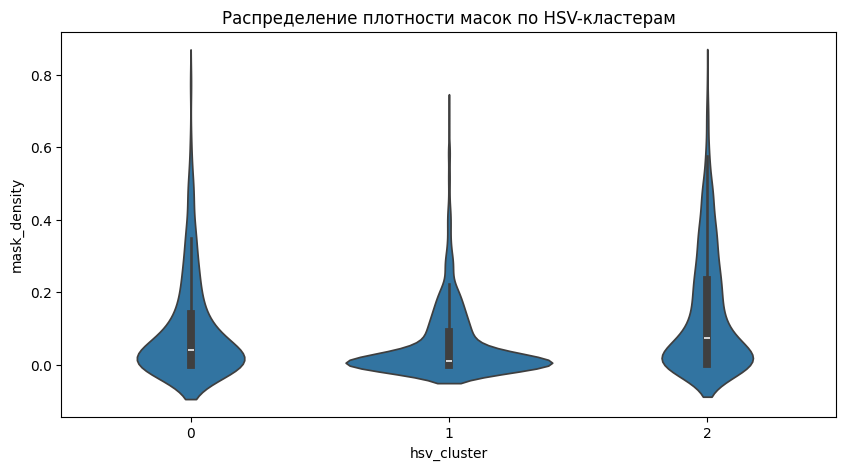

In [15]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x='hsv_cluster', y='mask_density')
plt.title('Распределение плотности масок по HSV-кластерам')
plt.show()

## Трансформации

In [9]:
train_transform = A.Compose([
    A.Resize(512, 512),
    
    # Геометрические трансформации
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),

    # Локальные искажения
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),

    # Цвет и контраст
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),

    # Дополнительно
   # A.CLAHE(p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    
    # Нормализация + тензор
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05, rotate_limit=10, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(512, 512),  
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

D:\Anaconda\envs\histoseg_env\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\555\AppData\Local\Temp\ipykernel_11476\3536417011.py:11: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
C:\Users\555\AppData\Local\Temp\ipykernel_11476\3536417011.py:20: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
C:\Users\555\AppData\Local\Temp\ipykernel_11476\3536417011.py:36: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),


In [39]:
class SegmentationDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask_transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        mask_path = self.df.loc[idx, "mask_path"]

        # Защитное чтение изображений
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            image = np.zeros((512, 512, 3), dtype=np.uint8)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Не удалось загрузить маску: {mask_path}")
            mask = np.zeros((512, 512), dtype=np.uint8)

        # Применяем трансформации
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].float()
            mask = (mask > 0).float()
            mask = mask.unsqueeze(0)  # [1, H, W]

        return {
            "image": image,
            "mask": mask,
            "mask_category": self.df.loc[idx, "mask_category"]  # если используется в train_sampler
        }

In [41]:
# веса только для train
train_weights = train_fold["sample_weight"].values
train_sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(train_weights),
    num_samples=len(train_weights),
    replacement=True
)

# датасеты
train_dataset = SegmentationDataset(train_fold, transform=train_transform)
val_dataset   = SegmentationDataset(val_fold,   transform=val_transform)

# Финальные лоадеры
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    sampler=train_sampler,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [39]:
# Посмотрим, сколько батчей какого типа модель увидит на 2000 итерациях

counter = Counter()

for i, batch in zip(range(2000), train_loader):
    cats = batch["mask_category"]          
    counter.update(cats)

print(counter.most_common())

[('Small', 377), ('Tiny', 349), ('Empty', 348), ('Full', 321)]


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


## Функция потерь (BCE + Dice)

In [45]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits)
        num = 2 * (logits * targets).sum(dim=(1, 2, 3)) + self.smooth
        den = logits.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + self.smooth
        return 1 - (num / den).mean()

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def loss_fn(preds, targets):
    return 0.5 * bce_loss(preds, targets) + 0.5 * dice_loss(preds, targets)

## U-Net

In [165]:
model = smp.Unet(
    encoder_name="resnet101",        
    encoder_weights="imagenet",    
    in_channels=3,          
    classes=1,
    decoder_attention_type='scse',
    activation=None                
).to(device)

In [51]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

NameError: name 'model' is not defined

## Тут случайно перезапустил ячейки при повторном просмотре. Поскольку этот ноутбук просто визуал работы и результат есть на Kaggle по ссылке в начале ноута, то перезапускать весь ноутбук не стал

In [175]:
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    loader = tqdm(loader, desc="Тренировка", leave=False)

    for batch in loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        # Пропустим полностью пустые батчи
        if masks.sum().item() == 0:
            continue

        optimizer.zero_grad()
        
        outputs = model(images)
        masks = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
        loss = loss_fn(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loader.set_postfix(loss=loss.item())

    return running_loss / max(len(loader), 1)

In [177]:
def evaluate(model, loader, loss_fn, device, use_tta=False):
    model.eval()
    val_loss = 0.0
    dices, ious = [], []

    loader = tqdm(loader, desc="Валидация", leave=False)

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            outputs = model(images)

            masks = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.detach().cpu().numpy().astype(int)
            masks = masks.detach().cpu().numpy().astype(int)

            for p, m in zip(preds, masks):
                ious.append(jaccard_score(m.flatten(), p.flatten()))
                intersect = (p * m).sum()
                union = p.sum() + m.sum()
                dices.append(2 * intersect / (union + 1e-7))

            loader.set_postfix(loss=loss.item())

    return val_loss / len(loader), np.mean(dices), np.mean(ious)

In [181]:
best_dice = 0.0
patience = 3
counter = 0
epochs = 20

pbar = trange(epochs, desc="Обучение модели", position=0)

for epoch in pbar:
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_dice, val_iou = evaluate(model, val_loader, loss_fn, device, use_tta=False)
    scheduler.step(val_dice)
    torch.cuda.empty_cache()

    # Обновим прогресс-бар
    pbar.set_description(f"[Эпоха {epoch+1}/{epochs}]")
    pbar.set_postfix({
        "TrainLoss": f"{train_loss:.4f}",
        "ValLoss": f"{val_loss:.4f}",
        "Dice": f"{val_dice:.4f}",
        "IoU": f"{val_iou:.4f}"
    })

    # Early stopping
    if val_dice > best_dice:
        best_dice = val_dice
        counter = 0
        torch.save(model.state_dict(), "best_model_UNet2.pth")
        print(f"Model saved at epoch {epoch+1} (Dice: {val_dice:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Тренировка: 100%|██████████| 175/175 [20:08<00:00,  4.69s/it, loss=0.584]
                                                                         
Валидация:  25%|██▌       | 11/44 [00:09<00:27,  1.20it/s, loss=0.62]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  36%|███▋      | 16/44 [00:13<00:23,  1.21it/s, loss=0.571]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  50%|█████     | 22/44 [00:18<00:17,  1.23it/s, loss=0

Model saved at epoch 1 (Dice: 0.2119)



Тренировка: 100%|██████████| 175/175 [16:19<00:00,  4.42s/it, loss=0.63]
                                                                        
Валидация:   0%|          | 0/44 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   5%|▍         | 2/44 [00:07<02:27,  3.50s/it, loss=0.46]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: 

Model saved at epoch 2 (Dice: 0.3504)



Тренировка: 100%|██████████| 175/175 [17:13<00:00,  4.97s/it, loss=0.463]
                                                                         
Валидация:   2%|▏         | 1/44 [00:01<01:06,  1.55s/it, loss=0.434]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   5%|▍         | 2/44 [00:03<01:06,  1.59s/it, loss=0.403]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 3/44 [00:04<01:02,  1.52s/it, loss=0.

Model saved at epoch 3 (Dice: 0.3926)



Тренировка: 100%|██████████| 175/175 [12:51<00:00,  4.05s/it, loss=0.596]
                                                                         
Валидация:   5%|▍         | 2/44 [00:01<00:25,  1.64it/s, loss=0.348]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 3/44 [00:01<00:23,  1.77it/s, loss=0.523]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_c

Model saved at epoch 4 (Dice: 0.4187)



Тренировка: 100%|██████████| 175/175 [14:40<00:00,  4.32s/it, loss=0.623]
                                                                         
Валидация:   0%|          | 0/44 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   2%|▏         | 1/44 [00:01<00:49,  1.14s/it, loss=0.382]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   5%|▍         | 2/44 [00:02<00:48,  1.16s/it, loss=0.328]D:\Anaconda\envs

Model saved at epoch 6 (Dice: 0.4453)



Тренировка: 100%|██████████| 175/175 [09:35<00:00,  3.51s/it, loss=0.39]
                                                                        
Валидация:   0%|          | 0/44 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   5%|▍         | 2/44 [00:02<00:48,  1.15s/it, loss=0.323]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565:

Model saved at epoch 7 (Dice: 0.4570)



Тренировка: 100%|██████████| 175/175 [12:07<00:00,  3.47s/it, loss=0.331]
                                                                         
Валидация:   0%|          | 0/44 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   2%|▏         | 1/44 [00:00<00:32,  1.34it/s, loss=0.389]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   5%|▍         | 2/44 [00:01<00:33,  1.27it/s, loss=0.293]D:\Anaconda\envs

Model saved at epoch 10 (Dice: 0.4664)



Тренировка: 100%|██████████| 175/175 [12:51<00:00,  4.38s/it, loss=0.274]
                                                                         
Валидация:   5%|▍         | 2/44 [00:06<02:23,  3.42s/it, loss=0.307]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 3/44 [00:10<02:23,  3.51s/it, loss=0.52]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_cl

Model saved at epoch 13 (Dice: 0.4668)



Тренировка: 100%|██████████| 175/175 [21:17<00:00,  6.79s/it, loss=0.246]
                                                                         
Валидация:   2%|▏         | 1/44 [00:03<02:19,  3.25s/it, loss=0.352]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 3/44 [00:09<02:14,  3.28s/it, loss=0.495]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  16%|█▌        | 7/44 [00:22<02:01,  3.28s/it, loss=0.

Early stopping triggered at epoch 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


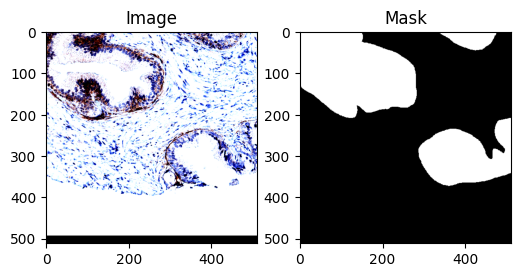

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


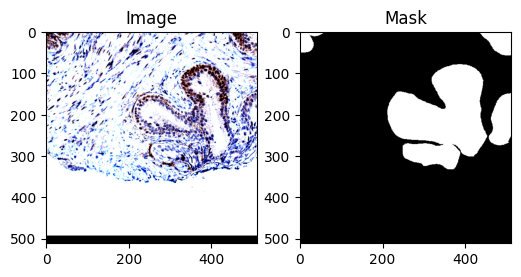

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


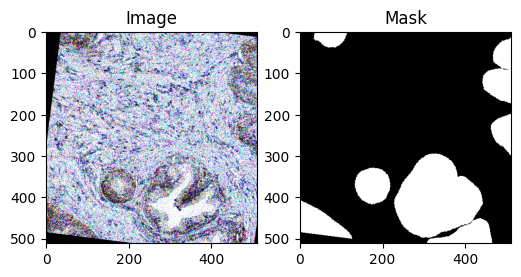

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


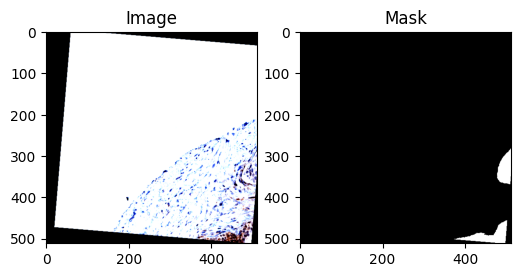

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5005665].


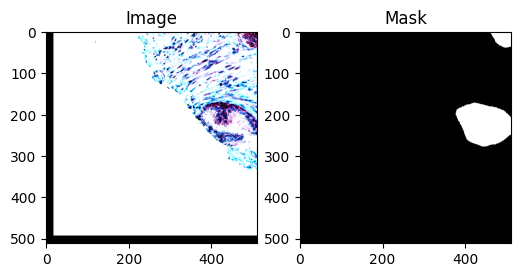

In [185]:
for i in range(5):
    sample = train_dataset[i]
    image = sample["image"]
    mask = sample["mask"]

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze().numpy(), cmap='gray')
    plt.title("Mask")
    plt.show()

## Решил посмотреть, что будет если не брать готовые веса

In [47]:
model = smp.Unet(
    encoder_name="resnet101",        
    encoder_weights=None,           
    in_channels=3,
    classes=1,
    decoder_attention_type='scse',
    activation=None
).to(device)

model.load_state_dict(torch.load(r"C:\Users\555\Desktop\BioML\Competition\best_model.pth"))
model.eval()

C:\Users\555\AppData\Local\Temp\ipykernel_22184\3416884392.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\555\Desktop\BioML

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

C:\Users\555\AppData\Local\Temp\ipykernel_22184\4205252689.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(), torch.inference_mode():
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2616663..2.465708].


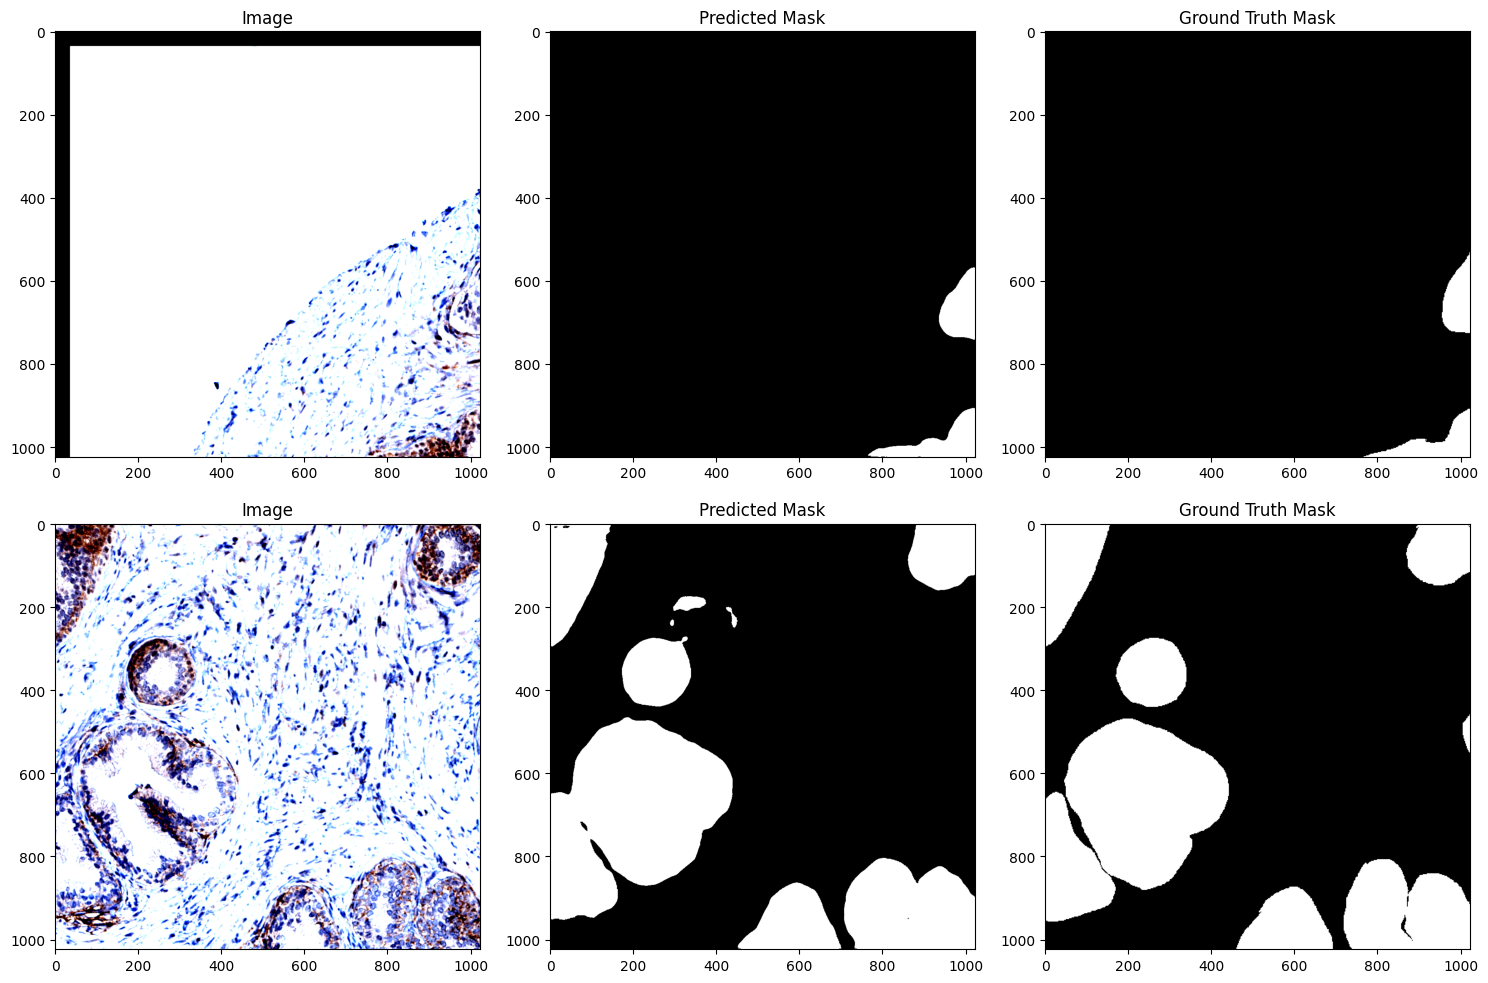

In [49]:
val_iter = iter(val_loader)
x, y = next(val_iter)

with torch.cuda.amp.autocast(), torch.inference_mode():
    pred = model(x.to(device))
    pred = torch.sigmoid(pred)

# Переводим в numpy
x = x.cpu()
y = y.cpu()
pred = pred.detach().cpu().numpy()

# Покажем N примеров
N = min(3, x.shape[0])
fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(15, 5 * N))

for i in range(N):
    axes[i, 0].imshow(x[i].permute(1, 2, 0))  # изображение
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow((pred[i][0] > 0.5), cmap="gray")  # предсказание
    axes[i, 1].set_title("Predicted Mask")

    axes[i, 2].imshow(y[i][0], cmap="gray")  # GT
    axes[i, 2].set_title("Ground Truth Mask")

plt.tight_layout()
plt.show()

In [59]:
# Путь к изображениям
test_images_path = r"C:\Users\555\Desktop\BioML\Competition\data\test\test"

# Загрузка DataFrame
test_df = pd.read_csv(r"C:\Users\555\Desktop\BioML\Competition\data\test\test.csv")
test_df["image_path"] = test_df["slice_id"].apply(lambda x: os.path.join(test_images_path, f"{x}.png"))

In [89]:
# Dataset
class SegmentationDatasetSubmit(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(test_images_path, f"{self.df.loc[idx, 'slice_id']}.png")
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, self.df.loc[idx, "slice_id"]

In [93]:
submission_path = r"C:\Users\555\Desktop\BioML\Competition\sample_submission.csv"

In [ ]:
def apply_tta(model, image):
    tta_transforms = [
        lambda x: x,
        lambda x: torch.flip(x, dims=[-1]),  # horizontal flip
        lambda x: torch.flip(x, dims=[-2]),  # vertical flip
    ]

    model.eval()
    preds = []

    with torch.no_grad():
        for tta in tta_transforms:
            aug_image = tta(image)
            pred = torch.sigmoid(model(aug_image))
            pred = tta(pred)  # Обратный поворот
            preds.append(pred)

    return torch.stack(preds).mean(dim=0)

In [153]:
# DataLoader
test_dataset = SegmentationDatasetSubmit(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Загрузка модели
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

submission = {"slice_id": [], "predicted_mask": []}

model.eval()

for x, slice_id in tqdm(test_loader):
    x = x.to(device)

    with torch.autocast("cuda"), torch.inference_mode():
        y_pred = apply_tta(model, x)

        mask = (y_pred[0, 0] > 0.5).cpu().numpy().astype(int).flatten()

    submission["slice_id"].append(str(slice_id[0]))
    submission["predicted_mask"].append(mask.tolist())

# Сохраняем
pd.DataFrame(submission).to_csv(submission_path, index=False)
print(f"[INFO] Submission сохранён: {submission_path}")

C:\Users\555\AppData\Local\Temp\ipykernel_22184\64103904.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
100%|███████

Всего изображений: 1151
Пример строки предсказания: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Длина маски: 262144
[INFO] Файл сохранён: C:\Users\555\Desktop\BioML\Competition\sample_submission.csv


In [143]:
sub = pd.read_csv(r"C:\Users\555\Desktop\BioML\Competition\sample_submission.csv")
print(sub.columns)
print(sub["predicted_mask"].iloc[0][:10])  

Index(['slice_id', 'predicted_mask'], dtype='object')
0 0 0 0 0 


In [145]:
sample = pd.read_csv(r"C:\Users\555\Desktop\BioML\Competition\sample_submission.csv")
assert set(sub["slice_id"]) == set(sample["slice_id"]) 

In [103]:
sub.head()

slice_id                                     predicted_mask
0  10044_0004  0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
1  10044_0007  0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
2  10044_0001  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3  10044_0002  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4  10044_0003  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...

In [119]:
isinstance(sub['predicted_mask'].iloc[0], str)

True

In [121]:
len(sub['predicted_mask'].iloc[0].split()) == 262144

True

In [123]:
set(sub['predicted_mask'].iloc[0].split()) <= {'0', '1'}

True

In [125]:
set(sub['slice_id']) == set(sub['slice_id'])

True

In [149]:
mask = sub['predicted_mask'].iloc[0]

# Проверка типа
print("Тип строки:", type(mask))

# Длина строки (по количеству пикселей)
print("Количество значений:", len(mask.split()))

# Уникальные значения
print("Уникальные элементы:", set(mask.split()))

# Совпадение ID
print("Совпадают ли ID:",
      set(sub['slice_id']) == set(sub['slice_id']))


Тип строки: <class 'str'>
Количество значений: 262144
Уникальные элементы: {'1', '0'}
Совпадают ли ID: True


In [105]:
sub.dtypes

slice_id          object
predicted_mask    object
dtype: object

In [107]:
for i, mask in enumerate(sub["predicted_mask"]):
    if len(mask.split()) != 512 * 512:
        print(f"Ошибка в маске {i} — длина {len(mask.split())}")
        break

In [109]:
import numpy as np

all_values = set()
for row in sub["predicted_mask"].sample(10):  # Проверим случайные строки
    all_values |= set(row.split())

print(all_values)  # Должно быть только {'0', '1'}

{'1', '0'}


In [111]:
print(set(test_df["slice_id"]) - set(sub["slice_id"])) 

set()


In [117]:
for row in sub["predicted_mask"].sample(5):
    print(set(row.split()))

{'1', '0'}
{'1', '0'}
{'1', '0'}
{'0'}
{'0'}


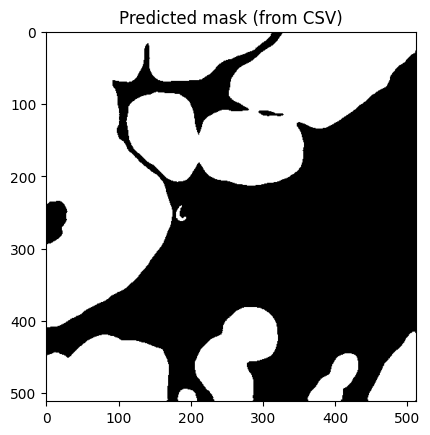

In [115]:
mask_str = sub["predicted_mask"].iloc[0]
mask = np.array(mask_str.split(), dtype=int).reshape(512, 512)

plt.imshow(mask, cmap="gray")
plt.title("Predicted mask (from CSV)")
plt.show()

In [203]:
import gc
import torch

# Удаляем ссылки на объекты
del model
del optimizer
del loss_fn

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated() / 1024**3, "GB allocated")
print(torch.cuda.memory_reserved() / 1024**3, "GB reserved")

NameError: name 'model' is not defined

In [205]:
del train_loader
del val_loader
del batch

print(torch.cuda.memory_allocated() / 1024**3, "GB allocated")
print(torch.cuda.memory_reserved() / 1024**3, "GB reserved")

0.7142210006713867 GB allocated
1.58984375 GB reserved


## Попробуем DeepLabV3Plus

In [55]:
train_loader = DataLoader(
    train_dataset,
    batch_size=6,       
    shuffle=True,
    num_workers=0,       
    pin_memory=False    
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,       
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [57]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",       
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)

In [59]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [61]:
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    loader = tqdm(loader, desc="Тренировка", leave=False)

    for batch in loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        # Пропустим полностью пустые батчи
        if masks.sum().item() == 0:
            continue

        optimizer.zero_grad()
        
        outputs = model(images)
        masks = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
        loss = loss_fn(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loader.set_postfix(loss=loss.item())

    return running_loss / max(len(loader), 1)

In [63]:
def evaluate(model, loader, loss_fn, device, use_tta=False):
    model.eval()
    val_loss = 0.0
    dices, ious = [], []

    loader = tqdm(loader, desc="Валидация", leave=False)

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            outputs = model(images)

            masks = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.detach().cpu().numpy().astype(int)
            masks = masks.detach().cpu().numpy().astype(int)

            for p, m in zip(preds, masks):
                ious.append(jaccard_score(m.flatten(), p.flatten()))
                intersect = (p * m).sum()
                union = p.sum() + m.sum()
                dices.append(2 * intersect / (union + 1e-7))

            loader.set_postfix(loss=loss.item())

    return val_loss / len(loader), np.mean(dices), np.mean(ious)

In [65]:
best_dice = 0.0
patience = 3
counter = 0
epochs = 20

pbar = trange(epochs, desc="Обучение модели", position=0)

for epoch in pbar:
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_dice, val_iou = evaluate(model, val_loader, loss_fn, device, use_tta=False)
    scheduler.step(val_dice)
    torch.cuda.empty_cache()

    # Обновим прогресс-бар
    pbar.set_description(f"[Эпоха {epoch+1}/{epochs}]")
    pbar.set_postfix({
        "TrainLoss": f"{train_loss:.4f}",
        "ValLoss": f"{val_loss:.4f}",
        "Dice": f"{val_dice:.4f}",
        "IoU": f"{val_iou:.4f}"
    })

    # Early stopping
    if val_dice > best_dice:
        best_dice = val_dice
        counter = 0
        torch.save(model.state_dict(), r"C:\Users\555\Desktop\BioML\Competition\best_model_DeepLabV3Plus2.pth")
        print(f"Model saved at epoch {epoch+1} (Dice: {val_dice:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Тренировка: 100%|██████████| 233/233 [01:55<00:00,  2.38it/s, loss=0.562]
                                                                         
Валидация:   0%|          | 0/88 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   6%|▌         | 5/88 [00:01<00:17,  4.75it/s, loss=0.677]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565

Model saved at epoch 1 (Dice: 0.3976)



Тренировка: 100%|██████████| 233/233 [01:53<00:00,  2.35it/s, loss=0.313]
                                                                         
Валидация:   0%|          | 0/88 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:01<00:17,  4.69it/s, loss=0.421]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  10%|█         | 9/88 [00:01<00:17,  4.60it/s, loss=0.47]D:\Anaconda\envs\

Model saved at epoch 2 (Dice: 0.4158)



Тренировка: 100%|██████████| 233/233 [01:54<00:00,  2.36it/s, loss=0.473]
                                                                         
Валидация:   2%|▏         | 2/88 [00:00<00:18,  4.72it/s, loss=0.345]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   6%|▌         | 5/88 [00:01<00:17,  4.83it/s, loss=0.767]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:01<00:17,  4.81it/s, loss=0.

Model saved at epoch 3 (Dice: 0.4165)



Тренировка: 100%|██████████| 233/233 [01:54<00:00,  2.36it/s, loss=0.35]
                                                                        
Валидация:   5%|▍         | 4/88 [00:00<00:18,  4.66it/s, loss=0.493]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:01<00:17,  4.67it/s, loss=0.474]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  17%|█▋        | 15/88 [00:03<00:15,  4.72it/s, loss=0.4

Model saved at epoch 4 (Dice: 0.4430)



Тренировка: 100%|██████████| 233/233 [01:54<00:00,  2.27it/s, loss=0.407]
                                                                         
Валидация:   0%|          | 0/88 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   2%|▏         | 2/88 [00:00<00:18,  4.69it/s, loss=0.352]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:01<00:17,  4.64it/s, loss=0.487]D:\Anaconda\envs

Model saved at epoch 6 (Dice: 0.4581)



Тренировка: 100%|██████████| 233/233 [01:53<00:00,  2.40it/s, loss=0.463]
                                                                         
Валидация:   2%|▏         | 2/88 [00:00<00:18,  4.67it/s, loss=0.304]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   6%|▌         | 5/88 [00:01<00:17,  4.80it/s, loss=0.726]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:01<00:17,  4.77it/s, loss=0.

Model saved at epoch 9 (Dice: 0.4646)



Тренировка: 100%|█████████▉| 232/233 [01:53<00:00,  2.04it/s, loss=0.327]
                                                                         
Валидация:   7%|▋         | 6/88 [00:01<00:17,  4.70it/s, loss=0.467]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  10%|█         | 9/88 [00:01<00:16,  4.73it/s, loss=0.33]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  16%|█▌        | 14/88 [00:02<00:15,  4.73it/s, loss=0.

Model saved at epoch 11 (Dice: 0.4749)



Тренировка: 100%|██████████| 233/233 [01:53<00:00,  2.43it/s, loss=0.368]
                                                                         
Валидация:   6%|▌         | 5/88 [00:01<00:17,  4.70it/s, loss=0.528]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  15%|█▍        | 13/88 [00:02<00:16,  4.67it/s, loss=0.193]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  16%|█▌        | 14/88 [00:02<00:15,  4.65it/s, loss=

Early stopping triggered at epoch 14


## Сильно лучше не стало (ожидаемо конечно)

## Для интереса попробуем PSPNet 

In [47]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,       
    shuffle=True,
    num_workers=0,       
    pin_memory=False    
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,       
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [49]:
model = smp.PSPNet(
    encoder_name="resnet101",      
    encoder_weights="imagenet",    
    classes=1,                    
    activation=None
).to(device)

In [51]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [57]:
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    loader = tqdm(loader, desc="Тренировка", leave=False)

    for batch in loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        # Пропустим полностью пустые батчи
        if masks.sum().item() == 0:
            continue

        optimizer.zero_grad()
        
        outputs = model(images)
        masks = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
        loss = loss_fn(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loader.set_postfix(loss=loss.item())

    return running_loss / max(len(loader), 1)

In [55]:
def evaluate(model, loader, loss_fn, device, use_tta=False):
    model.eval()
    val_loss = 0.0
    dices, ious = [], []

    loader = tqdm(loader, desc="Валидация", leave=False)

    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            outputs = model(images)

            masks = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.detach().cpu().numpy().astype(int)
            masks = masks.detach().cpu().numpy().astype(int)

            for p, m in zip(preds, masks):
                ious.append(jaccard_score(m.flatten(), p.flatten()))
                intersect = (p * m).sum()
                union = p.sum() + m.sum()
                dices.append(2 * intersect / (union + 1e-7))

            loader.set_postfix(loss=loss.item())

    return val_loss / len(loader), np.mean(dices), np.mean(ious)

In [59]:
best_dice = 0.0
patience = 3
counter = 0
epochs = 20

pbar = trange(epochs, desc="Обучение модели", position=0)

for epoch in pbar:
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_dice, val_iou = evaluate(model, val_loader, loss_fn, device, use_tta=False)
    scheduler.step(val_dice)
    torch.cuda.empty_cache()

    # Обновим прогресс-бар
    pbar.set_description(f"[Эпоха {epoch+1}/{epochs}]")
    pbar.set_postfix({
        "TrainLoss": f"{train_loss:.4f}",
        "ValLoss": f"{val_loss:.4f}",
        "Dice": f"{val_dice:.4f}",
        "IoU": f"{val_iou:.4f}"
    })

    # Early stopping
    if val_dice > best_dice:
        best_dice = val_dice
        counter = 0
        torch.save(model.state_dict(), r"C:\Users\555\Desktop\BioML\Competition\best_model_PSPNet2.pth")
        print(f"Model saved at epoch {epoch+1} (Dice: {val_dice:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Тренировка: 100%|██████████| 175/175 [00:59<00:00,  3.65it/s, loss=0.634]
                                                                         
Валидация:   7%|▋         | 6/88 [00:00<00:12,  6.35it/s, loss=0.49]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  10%|█         | 9/88 [00:01<00:12,  6.47it/s, loss=0.523]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  11%|█▏        | 10/88 [00:01<00:12,  6.40it/s, loss=0.5

Model saved at epoch 1 (Dice: 0.2232)



Тренировка: 100%|██████████| 175/175 [00:56<00:00,  3.84it/s, loss=0.604]
                                                                         
Валидация:   2%|▏         | 2/88 [00:00<00:13,  6.30it/s, loss=0.519]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:00<00:13,  6.21it/s, loss=0.54]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  10%|█         | 9/88 [00:01<00:12,  6.10it/s, loss=0.4

Model saved at epoch 2 (Dice: 0.2893)



Тренировка:  99%|█████████▉| 174/175 [00:56<00:00,  3.14it/s, loss=0.438]
                                                                         
Валидация:   0%|          | 0/88 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   6%|▌         | 5/88 [00:00<00:12,  6.39it/s, loss=0.646]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  18%|█▊        | 16/88 [00:02<00:11,  6.17it/s, loss=0.475]D:\Anaconda\env

Model saved at epoch 3 (Dice: 0.3101)



Тренировка: 100%|██████████| 175/175 [00:56<00:00,  3.65it/s, loss=0.301]
                                                                         
Валидация:   7%|▋         | 6/88 [00:00<00:12,  6.38it/s, loss=0.53]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  18%|█▊        | 16/88 [00:02<00:11,  6.32it/s, loss=0.348]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_c

Model saved at epoch 4 (Dice: 0.3450)



Тренировка: 100%|██████████| 175/175 [00:57<00:00,  3.84it/s, loss=0.429]
                                                                         
Валидация:   7%|▋         | 6/88 [00:00<00:12,  6.61it/s, loss=0.528]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  10%|█         | 9/88 [00:01<00:12,  6.18it/s, loss=0.346]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  18%|█▊        | 16/88 [00:02<00:11,  6.08it/s, loss=0

Model saved at epoch 5 (Dice: 0.3825)



Тренировка: 100%|██████████| 175/175 [00:56<00:00,  3.80it/s, loss=0.403]
                                                                         
Валидация:   7%|▋         | 6/88 [00:00<00:12,  6.67it/s, loss=0.505]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  16%|█▌        | 14/88 [00:02<00:11,  6.38it/s, loss=0.456]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  18%|█▊        | 16/88 [00:02<00:11,  6.25it/s, loss=

Model saved at epoch 6 (Dice: 0.3906)



Тренировка: 100%|██████████| 175/175 [00:56<00:00,  3.72it/s, loss=0.414]
                                                                         
Валидация:   0%|          | 0/88 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   5%|▍         | 4/88 [00:00<00:13,  6.46it/s, loss=0.407]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   6%|▌         | 5/88 [00:00<00:12,  6.48it/s, loss=0.675]D:\Anaconda\envs

Model saved at epoch 9 (Dice: 0.4003)



Тренировка: 100%|██████████| 175/175 [00:56<00:00,  3.90it/s, loss=0.493]
                                                                         
Валидация:   0%|          | 0/88 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:00<00:12,  6.48it/s, loss=0.435]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  18%|█▊        | 16/88 [00:02<00:12,  5.93it/s, loss=0.225]D:\Anaconda\env

Model saved at epoch 10 (Dice: 0.4157)



Тренировка: 100%|██████████| 175/175 [00:56<00:00,  3.69it/s, loss=0.52]
                                                                        
Валидация:   0%|          | 0/88 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   2%|▏         | 2/88 [00:00<00:13,  6.36it/s, loss=0.486]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565:

Model saved at epoch 13 (Dice: 0.4234)



Тренировка:  99%|█████████▉| 174/175 [00:56<00:00,  3.11it/s, loss=0.44]
                                                                        
Валидация:   6%|▌         | 5/88 [00:00<00:13,  6.30it/s, loss=0.64]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:00<00:13,  6.31it/s, loss=0.456]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  18%|█▊        | 16/88 [00:02<00:11,  6.14it/s, loss=0.20

Model saved at epoch 14 (Dice: 0.4247)



Тренировка: 100%|██████████| 175/175 [00:56<00:00,  3.75it/s, loss=0.465]
                                                                         
Валидация:   7%|▋         | 6/88 [00:00<00:12,  6.39it/s, loss=0.478]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  18%|█▊        | 16/88 [00:02<00:12,  5.71it/s, loss=0.194]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  24%|██▍       | 21/88 [00:03<00:11,  5.66it/s, loss=

Model saved at epoch 15 (Dice: 0.4270)



Тренировка: 100%|██████████| 175/175 [00:57<00:00,  3.59it/s, loss=0.539]
                                                                         
Валидация:   0%|          | 0/88 [00:00<?, ?it/s]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   2%|▏         | 2/88 [00:00<00:13,  6.53it/s, loss=0.36]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   5%|▍         | 4/88 [00:00<00:12,  6.49it/s, loss=0.428]D:\Anaconda\envs\

Model saved at epoch 18 (Dice: 0.4313)



Тренировка: 100%|██████████| 175/175 [00:56<00:00,  3.67it/s, loss=0.323]
                                                                         
Валидация:   6%|▌         | 5/88 [00:00<00:12,  6.59it/s, loss=0.596]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:   7%|▋         | 6/88 [00:00<00:12,  6.68it/s, loss=0.438]D:\Anaconda\envs\histoseg_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Валидация:  15%|█▍        | 13/88 [00:02<00:12,  6.17it/s, loss=0

Model saved at epoch 20 (Dice: 0.4338)


## Чуть хуже, но плюс-минус в одном диапазоне

## Решил попробовать Unet++

In [39]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,       
    shuffle=True,
    num_workers=0,       
    pin_memory=False    
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,       
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",        
    classes=1,
    activation=None,
    decoder_attention_type='scse'    
).to(device)

In [62]:
best_dice = 0.0
patience = 3
counter = 0
epochs = 20

pbar = trange(epochs, desc="Обучение модели", position=0)

for epoch in pbar:
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_dice, val_iou = evaluate(model, val_loader, loss_fn, device, use_tta=False)
    scheduler.step(val_dice)
    torch.cuda.empty_cache()

    # Обновим прогресс-бар
    pbar.set_description(f"[Эпоха {epoch+1}/{epochs}]")
    pbar.set_postfix({
        "TrainLoss": f"{train_loss:.4f}",
        "ValLoss": f"{val_loss:.4f}",
        "Dice": f"{val_dice:.4f}",
        "IoU": f"{val_iou:.4f}"
    })

    # Early stopping
    if val_dice > best_dice:
        best_dice = val_dice
        counter = 0
        torch.save(model.state_dict(), r"C:\Users\555\Desktop\BioML\Competition\best_model_UNetPlusPlus.pth")
        print(f"Model saved at epoch {epoch+1} (Dice: {val_dice:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Обучение модели:   0%|          | 0/20 [01:27<?, ?it/s]                  


KeyboardInterrupt: 

## Ожидаемо на моей карте- это очень долго. Ждать три дня мне совсем не хотелось ради чуть более высокой метрики. Всё равно соревноваться с людьми у кого есть кластер не смогу - решил я

# Но для успокоения совести решил попробовать Ensembles

## Shallow CNN

### Архитектура мета-модели (Shallow CNN)

In [41]:
class ShallowEnsembleCNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, out_channels, kernel_size=1)
        )

    def forward(self, x):
        return self.model(x)

### Загрузка сохранённых моделей

In [44]:
def load_model(model_class, weight_path):
    model = model_class()
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [46]:
def UNet():
    return smp.Unet(
        encoder_name="resnet101",           
        encoder_weights="imagenet",        
        in_channels=3,                   
        classes=1,                          
        decoder_attention_type='scse',     
        activation=None                    
    )

def DeepLabV3Plus():
    return smp.DeepLabV3Plus(
        encoder_name="resnet101",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    )

def PSPNet():
    return smp.PSPNet(
        encoder_name="resnet101",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    )

In [48]:
unet_model = load_model(UNet, r'C:\Users\555\Desktop\BioML\Competition\best_model_UNet2.pth')
deeplab_model = load_model(DeepLabV3Plus, r'C:\Users\555\Desktop\BioML\Competition\best_model_DeepLabV3Plus2.pth')
pspnet_model = load_model(PSPNet, r'C:\Users\555\Desktop\BioML\Competition\best_model_PSPNet2.pth')

C:\Users\555\AppData\Local\Temp\ipykernel_9076\1024403786.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=devi

### Получение предсказаний на train_dataset

In [52]:
def get_model_predictions(model, dataloader):
    preds = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            images = batch["image"].to(device)
            outputs = torch.sigmoid(model(images))
            preds.append(outputs.cpu())
    return torch.cat(preds, dim=0)  # (N, 1, H, W)

### Подготовка входа для ансамбля

In [54]:
# Получили предсказания трёх моделей
preds_unet = get_model_predictions(unet_model, train_loader)        # (N, 1, H, W)
preds_deeplab = get_model_predictions(deeplab_model, train_loader)  # (N, 1, H, W)
preds_pspnet = get_model_predictions(pspnet_model, train_loader)    # (N, 1, H, W)

# Объединяем в один тензор (N, 3, H, W)
ensemble_input = torch.cat([preds_unet, preds_deeplab, preds_pspnet], dim=1)

# Целевые значения
all_masks = []
for batch in train_loader:
    masks = batch["mask"]
    all_masks.append(masks)
ensemble_target = torch.cat(all_masks, dim=0)  # (N, 1, H, W)

100%|██████████| 175/175 [00:34<00:00,  5.06it/s]


### Обучение ShallowEnsembleCNN

In [57]:
ensemble_model = ShallowEnsembleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(ensemble_model.parameters(), lr=1e-4)

for epoch in range(30):
    ensemble_model.train()
    total_loss = 0.0

    with torch.no_grad():
        pred_unet_batches = get_model_predictions(unet_model, train_loader).chunk(len(train_loader))
        pred_deeplab_batches = get_model_predictions(deeplab_model, train_loader).chunk(len(train_loader))
        pred_pspnet_batches = get_model_predictions(pspnet_model, train_loader).chunk(len(train_loader))

    for i, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        inputs = torch.cat([
            pred_unet_batches[i],
            pred_deeplab_batches[i],
            pred_pspnet_batches[i]
        ], dim=1).to(device)  # shape: (B, 3, H, W)

        optimizer.zero_grad()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Эпоха {epoch+1}] Loss: {total_loss / len(train_loader):.4f}")

100%|██████████| 175/175 [00:35<00:00,  4.94it/s]


[Эпоха 1] Loss: 0.5417


100%|██████████| 175/175 [00:33<00:00,  5.30it/s]


[Эпоха 2] Loss: 0.4974


100%|██████████| 175/175 [00:34<00:00,  5.08it/s]


[Эпоха 3] Loss: 0.4719


100%|██████████| 175/175 [00:34<00:00,  5.09it/s]


[Эпоха 4] Loss: 0.4528


100%|██████████| 175/175 [00:30<00:00,  5.71it/s]


[Эпоха 5] Loss: 0.4307


100%|██████████| 175/175 [00:30<00:00,  5.66it/s]


[Эпоха 6] Loss: 0.4120


100%|██████████| 175/175 [00:31<00:00,  5.59it/s]


[Эпоха 7] Loss: 0.3884


100%|██████████| 175/175 [00:34<00:00,  5.08it/s]


[Эпоха 8] Loss: 0.3905


100%|██████████| 175/175 [00:35<00:00,  4.96it/s]


[Эпоха 9] Loss: 0.3629


100%|██████████| 175/175 [00:33<00:00,  5.16it/s]


[Эпоха 10] Loss: 0.3618


100%|██████████| 175/175 [00:32<00:00,  5.45it/s]


[Эпоха 11] Loss: 0.3467


100%|██████████| 175/175 [00:36<00:00,  4.81it/s]


[Эпоха 12] Loss: 0.3410


100%|██████████| 175/175 [00:31<00:00,  5.52it/s]


[Эпоха 13] Loss: 0.3354


100%|██████████| 175/175 [00:34<00:00,  5.01it/s]


[Эпоха 14] Loss: 0.3252


100%|██████████| 175/175 [00:35<00:00,  4.95it/s]


[Эпоха 15] Loss: 0.3235


100%|██████████| 175/175 [00:34<00:00,  5.01it/s]


[Эпоха 16] Loss: 0.3203


100%|██████████| 175/175 [00:35<00:00,  4.95it/s]


[Эпоха 17] Loss: 0.3157


100%|██████████| 175/175 [00:35<00:00,  4.97it/s]


[Эпоха 18] Loss: 0.3137


100%|██████████| 175/175 [00:35<00:00,  4.96it/s]


[Эпоха 19] Loss: 0.3193


100%|██████████| 175/175 [00:33<00:00,  5.18it/s]


[Эпоха 20] Loss: 0.3252


100%|██████████| 175/175 [00:34<00:00,  5.12it/s]


[Эпоха 21] Loss: 0.3155


100%|██████████| 175/175 [00:34<00:00,  5.03it/s]


[Эпоха 22] Loss: 0.3142


100%|██████████| 175/175 [00:34<00:00,  5.01it/s]


[Эпоха 23] Loss: 0.3053


100%|██████████| 175/175 [00:34<00:00,  5.03it/s]


[Эпоха 24] Loss: 0.3215


100%|██████████| 175/175 [00:34<00:00,  5.14it/s]


[Эпоха 25] Loss: 0.3113


100%|██████████| 175/175 [00:34<00:00,  5.01it/s]


[Эпоха 26] Loss: 0.3094


100%|██████████| 175/175 [00:33<00:00,  5.30it/s]


[Эпоха 27] Loss: 0.3014


100%|██████████| 175/175 [00:35<00:00,  4.90it/s]


[Эпоха 28] Loss: 0.3014


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


[Эпоха 29] Loss: 0.2982


100%|██████████| 175/175 [00:35<00:00,  4.93it/s]


[Эпоха 30] Loss: 0.2990


In [59]:
torch.save(ensemble_model.state_dict(), "best_model_ensemble_shallowcnn.pth")

In [61]:
from sklearn.metrics import f1_score, jaccard_score

def compute_metrics_batchwise(model, preds_tensor, target_tensor, batch_size=4, threshold=0.5):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for i in range(0, preds_tensor.shape[0], batch_size):
            batch_preds = preds_tensor[i:i+batch_size].to(device)           # (B, 3, H, W)
            batch_targets = target_tensor[i:i+batch_size].to(device)        # (B, 1, H, W)

            batch_outputs = torch.sigmoid(model(batch_preds)).cpu().numpy()
            batch_targets = batch_targets.cpu().numpy()

            batch_outputs_bin = (batch_outputs > threshold).astype(int)
            batch_targets_bin = (batch_targets > 0.5).astype(int)

            for j in range(batch_outputs.shape[0]):
                pred_flat = batch_outputs_bin[j].ravel()
                target_flat = batch_targets_bin[j].ravel()

                dice = f1_score(target_flat, pred_flat, zero_division=0)
                iou = jaccard_score(target_flat, pred_flat, zero_division=0)

                dice_scores.append(dice)
                iou_scores.append(iou)

    return np.mean(dice_scores), np.mean(iou_scores)

In [63]:
dice, iou = compute_metrics_batchwise(ensemble_model, ensemble_input, ensemble_target, batch_size=4)
print(f"Mean Dice: {dice:.4f}, Mean IoU: {iou:.4f}")

Mean Dice: 0.0000, Mean IoU: 0.0000


In [65]:
batch_preds = ensemble_input[:4].to(device)
with torch.no_grad():
    outputs = torch.sigmoid(ensemble_model(batch_preds)).cpu()
print("Min:", outputs.min().item(), "Max:", outputs.max().item(), "Mean:", outputs.mean().item())

Min: 0.05183768272399902 Max: 0.30033427476882935 Mean: 0.10767988860607147


In [67]:
dice, iou = compute_metrics_batchwise(
    ensemble_model,
    ensemble_input,
    ensemble_target,
    batch_size=4,
    threshold=0.2  # или даже 0.15
)
print(f"Mean Dice: {dice:.4f}, Mean IoU: {iou:.4f}")


Mean Dice: 0.0011, Mean IoU: 0.0006


In [73]:
class StaticModel(nn.Module):
    def __init__(self, predictions):
        super().__init__()
        self.preds = predictions  # (N, 1, H, W)

    def forward(self, x):
        # x имеет форму (B, 3, H, W), нужно вернуть (B, 1, H, W)
        batch_size = x.shape[0]
        self._i = getattr(self, '_i', 0)  # индекс первого элемента
        preds_batch = self.preds[self._i : self._i + batch_size].to(x.device)
        self._i += batch_size
        return preds_batch
        
# усреднение без обучения
ensemble_soft = (preds_unet + preds_deeplab + preds_pspnet) / 3

# создаём "модель", которая просто возвращает ensemble_soft
dummy_model = StaticModel(ensemble_soft)

dice_soft, iou_soft = compute_metrics_batchwise(
    dummy_model, ensemble_input, ensemble_target,
    batch_size=4,
    threshold=0.2
)
print(f"Soft Voting → Dice: {dice_soft:.4f}, IoU: {iou_soft:.4f}")

Soft Voting → Dice: 0.1345, IoU: 0.0845


## И ничего не вышло

In [62]:
class ResidualEnsemble(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.skip = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.skip(x)
        x = self.block(x)
        x = x + residual
        return self.out(x)


In [77]:
ensemble_model = ResidualEnsemble().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(ensemble_model.parameters(), lr=1e-4)

In [70]:
with torch.no_grad():
    pred_unet_batches = get_model_predictions(unet_model, train_loader).chunk(len(train_loader))
    pred_deeplab_batches = get_model_predictions(deeplab_model, train_loader).chunk(len(train_loader))
    pred_pspnet_batches = get_model_predictions(pspnet_model, train_loader).chunk(len(train_loader))

100%|██████████| 175/175 [00:34<00:00,  5.05it/s]


In [83]:
for epoch in range(30):
    ensemble_model.train()
    total_loss = 0.0

    for i, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        inputs = torch.cat([
            pred_unet_batches[i],
            pred_deeplab_batches[i],
            pred_pspnet_batches[i]
        ], dim=1).to(device)  # (B, 3, H, W)

        optimizer.zero_grad()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Эпоха {epoch+1}] Loss: {total_loss / len(train_loader):.4f}")

[Эпоха 1] Loss: 0.4190
[Эпоха 2] Loss: 0.3832
[Эпоха 3] Loss: 0.3371
[Эпоха 4] Loss: 0.3113
[Эпоха 5] Loss: 0.3200
[Эпоха 6] Loss: 0.2955
[Эпоха 7] Loss: 0.3023
[Эпоха 8] Loss: 0.3051
[Эпоха 9] Loss: 0.3161
[Эпоха 10] Loss: 0.3041
[Эпоха 11] Loss: 0.2989
[Эпоха 12] Loss: 0.3051
[Эпоха 13] Loss: 0.2975
[Эпоха 14] Loss: 0.2855
[Эпоха 15] Loss: 0.3017
[Эпоха 16] Loss: 0.3148
[Эпоха 17] Loss: 0.3067
[Эпоха 18] Loss: 0.3013
[Эпоха 19] Loss: 0.3048
[Эпоха 20] Loss: 0.2878
[Эпоха 21] Loss: 0.3086
[Эпоха 22] Loss: 0.2973
[Эпоха 23] Loss: 0.2979
[Эпоха 24] Loss: 0.3099
[Эпоха 25] Loss: 0.2996
[Эпоха 26] Loss: 0.3025
[Эпоха 27] Loss: 0.3060
[Эпоха 28] Loss: 0.3002
[Эпоха 29] Loss: 0.2966
[Эпоха 30] Loss: 0.2966


In [85]:
torch.save(ensemble_model.state_dict(), r'C:\Users\555\Desktop\BioML\Competition\best_model_ResidualEnsemble.pth')

In [87]:
dice, iou = compute_metrics_batchwise(
    ensemble_model,
    ensemble_input,
    ensemble_target,
    batch_size=4,
    threshold=0.2  # можно уменьшить до 0.15
)
print(f"Residual Ensemble → Dice: {dice:.4f}, IoU: {iou:.4f}")


Residual Ensemble → Dice: 0.0009, IoU: 0.0005


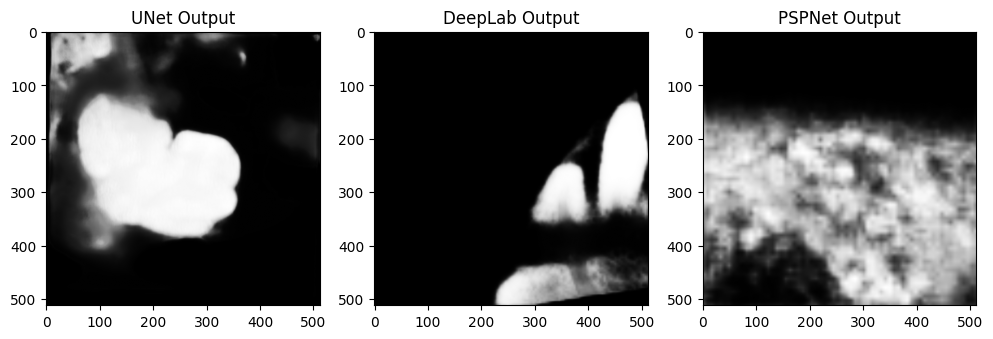

In [89]:
import matplotlib.pyplot as plt

pred_unet_vis = pred_unet_batches[0][0].cpu().squeeze().numpy()
pred_deeplab_vis = pred_deeplab_batches[0][0].cpu().squeeze().numpy()
pred_pspnet_vis = pred_pspnet_batches[0][0].cpu().squeeze().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("UNet Output")
plt.imshow(pred_unet_vis, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("DeepLab Output")
plt.imshow(pred_deeplab_vis, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("PSPNet Output")
plt.imshow(pred_pspnet_vis, cmap="gray")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5805321..2.465708].


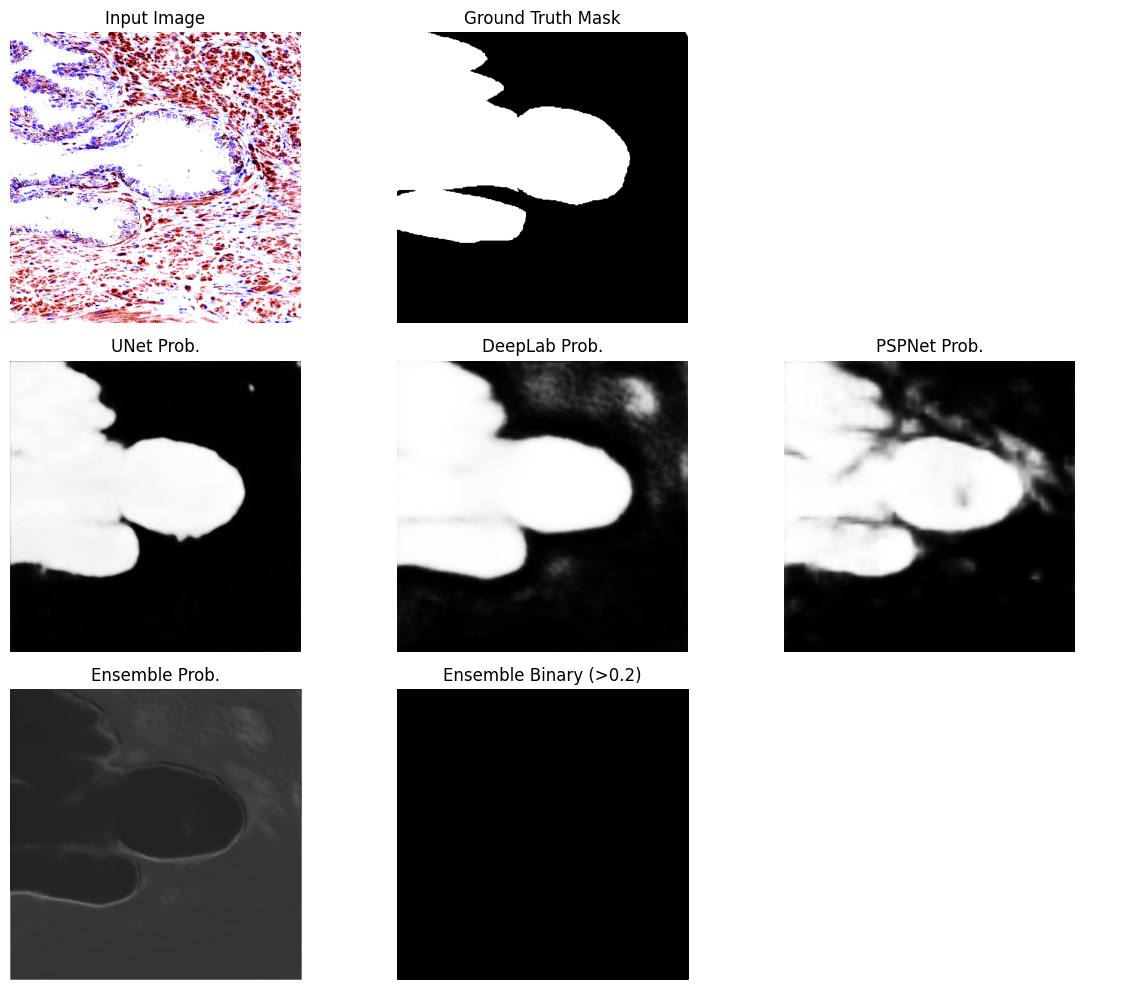

In [91]:
batch = next(iter(train_loader))
image = batch["image"][0].unsqueeze(0).to(device)  # (1, C, H, W)
mask = batch["mask"][0].squeeze().cpu().numpy()

# получим выходы базовых моделей
with torch.no_grad():
    out_unet = torch.sigmoid(unet_model(image)).squeeze().cpu().numpy()
    out_deeplab = torch.sigmoid(deeplab_model(image)).squeeze().cpu().numpy()
    out_pspnet = torch.sigmoid(pspnet_model(image)).squeeze().cpu().numpy()

# вход для ансамбля
ensemble_input = torch.cat([
    torch.sigmoid(unet_model(image)),
    torch.sigmoid(deeplab_model(image)),
    torch.sigmoid(pspnet_model(image))
], dim=1)

# получим выход ансамбля
with torch.no_grad():
    out_ensemble = torch.sigmoid(ensemble_model(ensemble_input)).squeeze().cpu().numpy()

# отрисовка
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# вход и маска
axes[0, 0].imshow(image[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
axes[0, 0].set_title("Input Image")
axes[0, 1].imshow(mask, cmap="gray")
axes[0, 1].set_title("Ground Truth Mask")
axes[0, 2].axis("off")

# soft outputs
axes[1, 0].imshow(out_unet, cmap="gray")
axes[1, 0].set_title("UNet Prob.")
axes[1, 1].imshow(out_deeplab, cmap="gray")
axes[1, 1].set_title("DeepLab Prob.")
axes[1, 2].imshow(out_pspnet, cmap="gray")
axes[1, 2].set_title("PSPNet Prob.")

# outputs after threshold (0.2)
th = 0.2
axes[2, 0].imshow(out_ensemble, cmap="gray")
axes[2, 0].set_title("Ensemble Prob.")
axes[2, 1].imshow((out_ensemble > th).astype(int), cmap="gray")
axes[2, 1].set_title(f"Ensemble Binary (>{th})")
axes[2, 2].axis("off")

# общие настройки
for ax in axes.ravel():
    ax.axis("off")
plt.tight_layout()
plt.show()

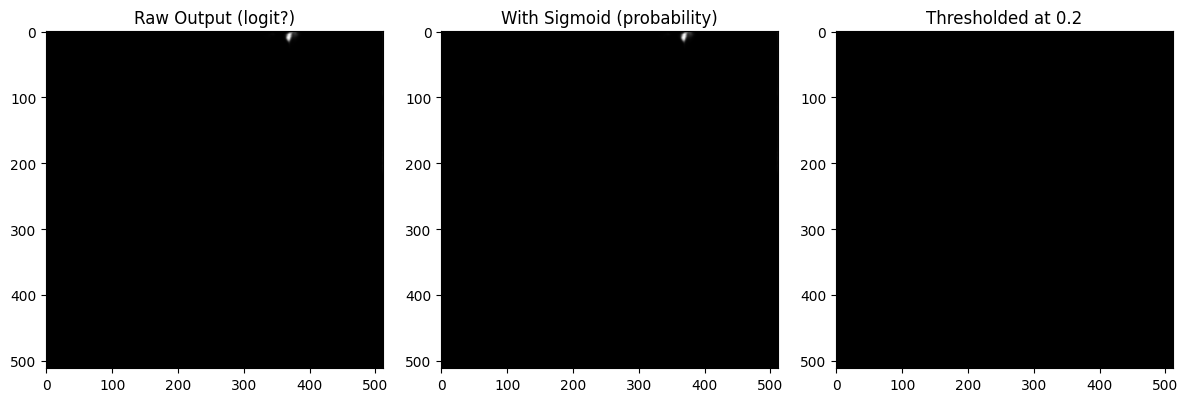

In [93]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Выбираем одну картинку из предсказаний
example = preds_unet[0].cpu().detach()

# Пробуем без sigmoid
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(example.squeeze(), cmap='gray')
plt.title("Raw Output (logit?)")

# Пробуем c sigmoid
plt.subplot(1, 3, 2)
plt.imshow(torch.sigmoid(example).squeeze(), cmap='gray')
plt.title("With Sigmoid (probability)")

# Пробуем бинаризовать
plt.subplot(1, 3, 3)
plt.imshow((torch.sigmoid(example) > 0.2).squeeze(), cmap='gray')
plt.title("Thresholded at 0.2")

plt.tight_layout()
plt.show()

## Причины слабых метрик ансамбля:
– базовые модели (UNet, DeepLab, PSPNet) показывали неидеальные результаты сами по себе, с Dice ≈ 0.3–0.35;

– ансамбль в лоб (усреднение, простая CNN, residual meta-net) не улучшил ситуацию, потому что входные маски были «шумными» и неуверенными;

– срабатывает принцип garbage in — garbage out: если у всех участников ансамбля высока неопределённость, мета-модель лишь усиливает шум;

– кроме того, выборка маленькая, а ресурсов GPU ограничено → нельзя дообучить или взять более тяжёлую архитектуру.

## Напоследок решил попробовать ResidualEnsemble  + FocalLoss

In [78]:
class FocalLossAfterSigmoid(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, reduction="mean"):
        super(FocalLossAfterSigmoid, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        probs = torch.sigmoid(inputs)  # явное применение
        bce_loss = -(
            targets * torch.log(probs + 1e-8) +
            (1 - targets) * torch.log(1 - probs + 1e-8)
        )
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

In [64]:
model = ResidualEnsemble().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [74]:
with torch.no_grad():
    pred_unet_batches = get_model_predictions(unet_model, train_loader).chunk(len(train_loader))
    pred_deeplab_batches = get_model_predictions(deeplab_model, train_loader).chunk(len(train_loader))
    pred_pspnet_batches = get_model_predictions(pspnet_model, train_loader).chunk(len(train_loader))

100%|██████████| 175/175 [00:33<00:00,  5.26it/s]


In [80]:
epochs = 30
lr = 1e-3
batch_size = 4

# Focal Loss
criterion_focal = FocalLoss(alpha=0.8, gamma=2.0)

# Модель
res_model_focal = ResidualEnsemble(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(res_model_focal.parameters(), lr=1e-3)

# Обучение
print("Обучение ResidualEnsemble с FocalLoss")

for epoch in range(30):
    res_model_focal.train()
    total_loss = 0.0

    for i, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        inputs = torch.cat([
            pred_unet_batches[i],
            pred_deeplab_batches[i],
            pred_pspnet_batches[i]
        ], dim=1).to(device)  # (B, 3, H, W)

        optimizer.zero_grad()
        outputs = res_model_focal(inputs)
        loss = criterion_focal(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Эпоха {epoch+1}] Loss: {total_loss / len(train_loader):.4f}")

Обучение ResidualEnsemble с FocalLoss
[Эпоха 1] Loss: 0.0679
[Эпоха 2] Loss: 0.0653
[Эпоха 3] Loss: 0.0654
[Эпоха 4] Loss: 0.0653
[Эпоха 5] Loss: 0.0663
[Эпоха 6] Loss: 0.0662
[Эпоха 7] Loss: 0.0667
[Эпоха 8] Loss: 0.0666
[Эпоха 9] Loss: 0.0642
[Эпоха 10] Loss: 0.0652


KeyboardInterrupt: 

## И снова неудача
– тестировал замену BCE на Focal, но модель не сходилась (на таком небольшом датасете и слабых фичах это нормально).

– BCEWithLogits работал стабильнее, хоть и не давал прироста.

## ResidualEnsemble  + BCEWithLogitsLoss

In [85]:
res_model_bce = ResidualEnsemble(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(res_model_bce.parameters(), lr=1e-3)
criterion_bce = nn.BCEWithLogitsLoss()

# Обучение
print("Обучение ResidualEnsemble с BCEWithLogitsLoss")
epochs = 30
for epoch in range(epochs):
    res_model_bce.train()
    total_loss = 0.0

    for i, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        inputs = torch.cat([
            pred_unet_batches[i],      # вероятности или логиты — в зависимости от того, что подавали
            pred_deeplab_batches[i],
            pred_pspnet_batches[i]
        ], dim=1).to(device)  # (B, 3, H, W)

        optimizer.zero_grad()
        outputs = res_model_bce(inputs)
        loss = criterion_bce(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Эпоха {epoch+1}] Loss: {total_loss / len(train_loader):.4f}")

Обучение ResidualEnsemble с BCEWithLogitsLoss
[Эпоха 1] Loss: 0.3765
[Эпоха 2] Loss: 0.3063
[Эпоха 3] Loss: 0.3058
[Эпоха 4] Loss: 0.2978
[Эпоха 5] Loss: 0.2934
[Эпоха 6] Loss: 0.3006
[Эпоха 7] Loss: 0.2925
[Эпоха 8] Loss: 0.3029
[Эпоха 9] Loss: 0.2912
[Эпоха 10] Loss: 0.2978
[Эпоха 11] Loss: 0.3079
[Эпоха 12] Loss: 0.2896
[Эпоха 13] Loss: 0.3088
[Эпоха 14] Loss: 0.2998
[Эпоха 15] Loss: 0.3114
[Эпоха 16] Loss: 0.2995
[Эпоха 17] Loss: 0.3064
[Эпоха 18] Loss: 0.3111
[Эпоха 19] Loss: 0.3138
[Эпоха 20] Loss: 0.2992
[Эпоха 21] Loss: 0.3142
[Эпоха 22] Loss: 0.3042
[Эпоха 23] Loss: 0.2937
[Эпоха 24] Loss: 0.3086
[Эпоха 25] Loss: 0.2967
[Эпоха 26] Loss: 0.2958
[Эпоха 27] Loss: 0.2914
[Эпоха 28] Loss: 0.2915
[Эпоха 29] Loss: 0.2991
[Эпоха 30] Loss: 0.2917


## Времени было мало, мучачть виокарту я не хотел и решил переключиться на другие проекты, поэтому сделал предсказание для кеггла и отправил его (была проблема с пониманием в каком формате ждут сабмит). Там получил метрику DICE 0.633, что в принципе не так плохо, учитывая на чём работал


In [11]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",      
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load("C:/Users/555/Desktop/BioML/Competition/best_model_DeepLabV3Plus2.pth", map_location="cuda" if torch.cuda.is_available() else "cpu"))
model.eval()

C:\Users\555\AppData\Local\Temp\ipykernel_11476\3650417276.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Users/555/Desktop/BioML/C

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [13]:
class SegmentationDatasetSubmit(Dataset):
    """
    A custom Dataset class for competition.

    Args:
        dataframe (pd.DataFrame): DataFrame containing 'ImageId' and 'MaskId' columns.
        transform (callable, optional): Optional transform to be applied on the input image.
    """

    def __init__(
        self,
        dataframe,
        transform=None,
    ):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        slice_id = self.df.loc[idx, "slice_id"]

        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            raise ValueError(f"Ошибка загрузки изображения: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, slice_id

In [15]:
test_df = pd.read_csv(r"C:/Users/555/Desktop/BioML/Competition/data/test/test.csv")

# Добавим абсолютные пути
test_df["image_path"] = test_df["slice_id"].apply(
    lambda x: f"C:/Users/555/Desktop/BioML/Competition/data/test/test/{x}.png"
)

dataset = SegmentationDatasetSubmit(test_df, transform=val_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [17]:
print(test_df["image_path"].iloc[0])
print(Path(test_df["image_path"].iloc[0]).exists())


C:/Users/555/Desktop/BioML/Competition/data/test/test/10044_0004.png
True


In [19]:
def rle_encode(mask: np.ndarray) -> str:
    """
    Convert a 2‑D binary mask to the Kaggle run‑length encoding format.

    Parameters
    ----------
    mask : np.ndarray
        2‑D array of type bool, int, or uint8 where non‑zero pixels are foreground.

    Returns
    -------
    str
        Space‑separated "start length start length ..." string.
        An empty string is returned when the mask is empty.

    Notes
    -----
    • Pixels are enumerated column‑wise with 1‑based indexing.  
    • The function tolerates non‑boolean dtypes by thresholding `>0`.  
    """
    if mask.ndim != 2:
        raise ValueError("Input mask must be 2‑D")

    # Convert to 1‑D column‑major vector of 0 and 1
    pixels = (mask > 0).T.flatten()        # transpose then flatten (C order) == flatten(order="F")

    if pixels.sum() == 0:
        return "0"                          # empty mask

    # Pad zeros at both ends to catch runs that start or end at image borders
    padded = np.concatenate([[0], pixels, [0]])
    changes = np.where(padded[1:] != padded[:-1])[0] + 1   # indices where value flips

    runs = changes[1::2] - changes[0::2]                   # run lengths
    starts = changes[0::2]                                 # 1‑based already

    rle = np.column_stack((starts, runs)).flatten()
    return " ".join(str(x) for x in rle)

In [21]:
submission = {"id": [], "rle_mask": []}

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [37]:
submission = {"id": [], "rle_mask": []}
model.to(device)
model.eval()

for data in tqdm(dataloader):
    x = data[0].to(device).float()
    slice_id = data[1]

    with torch.inference_mode():
        ypred = model(x)

    submission["id"].append(slice_id[0])
    submission["rle_mask"].append(
        rle_encode((ypred[0, 0, ...] > 0).detach().cpu().numpy())
    )

100%|██████████| 1151/1151 [00:46<00:00, 24.98it/s]


In [41]:
pd.DataFrame(submission).to_csv(r"C:\Users\555\Desktop\BioML\Competition\submission_deeplab.csv", index=False)

In [ ]:
model.to(device) 

submission = {"id": [], "rle_mask": []}
model.eval()

for data in tqdm(dataloader):
    x = data[0].to(device).float()
    slice_id = data[1]

    with torch.inference_mode():
        ypred = model(x)

    mask = torch.sigmoid(ypred[0, 0]) > 0.5  
    submission["id"].append(slice_id[0])
    submission["rle_mask"].append(
        rle_encode(mask.detach().cpu().numpy())
    )

In [ ]:
pd.DataFrame(submission).to_csv(r"C:\Users\555\Desktop\BioML\Competition\submission_deeplab2.csv", index=False)

# Итоговый вывод:
В работе были протестированы три популярные архитектуры для семантической сегментации (UNet, DeepLab, PSPNet) и построен ансамбль моделей.  

- Базовые модели обучились, но показывали умеренные метрики (Dice ~0.3–0.35), что связано с ограниченностью вычислительных ресурсов (GPU RTX 2070, batch-size 4–8) и сложностью датасета.  
- Попытки построить ансамбль (усреднение вероятностей, soft voting, простая CNN и residual meta-model) не улучшили качество. Причины:  
  * ансамбль объединяет слабые предсказания, поэтому итоговый результат остаётся слабым;  
  * мета-сети не имели достаточного объёма данных для корректного обучения;  
  * валидационные метрики подтверждают, что ансамбль не приносит прироста.  
- Альтернативные функции потерь (Focal Loss) также не дали улучшения — BCEWithLogits оказался стабильнее.  

**Главный результат**: удалось пройти весь цикл экспериментов — от отдельных архитектур до ансамблей и анализа причин их провала. Несмотря на низкие метрики, работа дала ценный опыт:  
1. ограничения вычислительных ресурсов сильно влияют на применимость архитектур (точно не открытие);  
2. ансамбли не «магическая палочка» — их эффективность зависит от силы базовых моделей (что конечно очевидно);  
3. важно уметь объяснить неудачи и зафиксировать найденные пределы (немного самоутешения).  

Дальнейшие шаги при наличии более мощного оборудования:  
- запуск более тяжёлых моделей (UNet++, DeepLabv3+), а в идеале конечно SAM/SAM2 (хотя для этого датасета это будет наверно черезчур) 
- обучение с увеличением числа эпох и сложными аугментациями,  
- использование предобученных весов на схожих датасетах.  

В текущих условиях было показано, что даже при ограниченном железе можно исследовать архитектуры, протестировать ансамбли, получить практический опыт, который пригодится в будущих проектах и даже по итогу получить не совсем ужасную метрику.